# Project 15.32: Overcoming critical slowing down

Author: Tianlu Liu, YiTao Huang

Date: December 2025

Environment: Python 3.13, C++17

----

Project 15.32 primarily focuses on addressing the "critical slowing down" problem encountered when simulating the Ising model near its critical point using Monte Carlo methods.

As the system approaches the critical temperature $T_c$, the correlation length $\xi(T)$ increases sharply as

$$
\xi(T) \sim L \sim |T - T_c|^{-\nu}
$$

with $\nu = 1$ for the two-dimensional Ising model. The autocorrelation time $\tau(T)$ is given by

$$
\tau(T) \sim \xi(T)^z \sim |T - T_c|^{-z\nu}
$$

where $z \approx 2.167$ for single-spin-flip update.

This leads to a significant drop in efficiency for conventional local dynamics algorithms—such as the Metropolis single-spin-flip update when the temperature is close to $T_c$ or the system size $L$ grows.

The goal of this project is to explore and implement a cluster-flipping algorithms (Wolff algorithm), which simultaneously flip groups of correlated spins to effectively mitigate critical slowing down.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numba import njit
from tqdm import tqdm
from ising_model import *


plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'


J_val = 1.0  # ferromagnetic case
k_B = 1.0 # normalize Boltzmann constant

The Wolff algorithm has been implemented in C++, here just gives the cardinal procedures (in the view of programming):
1. Creat a set *cluster* and a deque *check*, both initialized as empty
2. Randomly select a spin as the seed, add it to both *cluster* and *check*
3. While *check* is not empty:
   1. Pop the first spin from *check* as *current*
   2. Consider the four nearest neighbors of *current* as *neighbors*
   3. For each *neighbor* in *neighbors*, if *neighbor* has **the same spin** as *current* and is not in *cluster*, add it to *cluster* and the tail of *check* with probability
    $$P_{\text{add}} = 1 - e^{-2J/k_BT}$$
4. Flip all spins in *cluster*

Steps 1-4 constitute one single Wolff update. Repeat for sufficient times to achieve equilibrium configuration.

## Critical Slowing Down

The phenomenon of critical slowing down can be quantitatively analyzed using the autocorrelation function and autocorrelation time.

The autocorrelation function $C(t)$ for a time series of measurements $O_i$ is defined as:

$$
C(t) = \frac{\langle O_i O_{i+t} \rangle - \langle O_i \rangle^2}{\langle O_i^2 \rangle - \langle O_i \rangle^2}
$$

The autocorrelation time $\tau$ is then defined as the integral of the autocorrelation function:

$$
\tau = \sum_{t=1} C(t)
$$

and Tthe sum is cut off at the first negative value of $C(t)$.

In [2]:
@njit
def autocorr_func(x):
    n = len(x)
    x_mean = np.mean(x)
    c0 = np.sum((x - x_mean) ** 2) / n
    acf = np.zeros(n)
    for lag in range(n):
        c_lag = np.sum((x[:n - lag] - x_mean) * (x[lag:] - x_mean)) / n
        acf[lag] = c_lag / c0
    return acf

@njit
def integrated_autocorr_time(acf):
    tau = 0.5  # Start with the zero lag
    for lag in range(1, len(acf)):
        if acf[lag] <= 0:
            break
        tau += acf[lag]
    return tau

To facilitate simulation more conveniently, we encapsulate the simplest multiple-flip process.

In [4]:
def sim_ising(s, kBT, n_therm, n_meas, method = "metropolis", lag = 1):
    multipleSteps(s, kBT, n_therm, method, False)
    e_seq, m_seq, cluster_sizes = multipleSteps(s, kBT, n_meas, method, True, lag)
    return e_seq, m_seq, cluster_sizes

In [4]:
L = 16
T = np.arange(1.8, 2.8, 0.1)

steps_wolff_thermal = 100
steps_wolff = 200
steps_metro_thermal = 200 * L * L
steps_metro = 300 * L * L

tau_wolff = []
tau_metro = []
cluster_sizes = []

pbar = tqdm(T, desc="Metropolis")
for t in pbar:
    tau_metro_val = 0
    for _ in range(50):  # repeat to avoid outliers
        s = IsingSpins(L, L, J_val)
        e_samples, m_samples, _ = sim_ising(s, t, steps_metro_thermal, steps_metro, method="metropolis", lag=L*L)
        acf_metro = autocorr_func(m_samples)
        tau_metro_val += integrated_autocorr_time(acf_metro)
    tau_metro.append(tau_metro_val / 50) 
pbar.close()

pbar = tqdm(T, desc="Wolff")
for t in pbar: 
    tau_wolff_val = 0
    cluster_val = 0
    for _ in range(50):  # single run is sufficient
        s = IsingSpins(L, L, J_val)
        e_samples, m_samples, cluster_size = sim_ising(s, t, steps_wolff_thermal, steps_wolff, method="wolff", lag=1)
        acf_wolff = autocorr_func(m_samples)
        tau_wolff_val += integrated_autocorr_time(acf_wolff)
        cluster_val += cluster_size

    tau_wolff.append(tau_wolff_val / 50)  
    cluster_sizes.append(cluster_val / 50)
pbar.close()

print('tau_metropolis:\n', np.round(tau_metro, 3))
print('tau_wolff:\n', np.round(tau_wolff, 3))
print('cluster_sizes:\n', np.round(cluster_sizes, 3))


Wolff: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]

tau_metropolis:
 [ 0.954  1.686  3.398  4.252 10.172 15.831 17.492 17.488 12.035 10.16 ]
tau_wolff:
 [0.554 0.605 0.735 0.986 1.655 2.097 2.218 2.661 2.266 2.114]
cluster_sizes:
 [234.18 225.8  213.   193.56 167.24 125.74  82.86  51.88  33.32  22.9 ]


To compare $\tau$ of the two algorithms, we need to modify $\tau_{cf}$ (cluster-flip) to make the two autocorr-time have the same unit.

$$\tau_{wolff} = \tau_{cf} \frac{\langle c \rangle}{L^2}$$

where $\langle c \rangle$ is the average cluster size

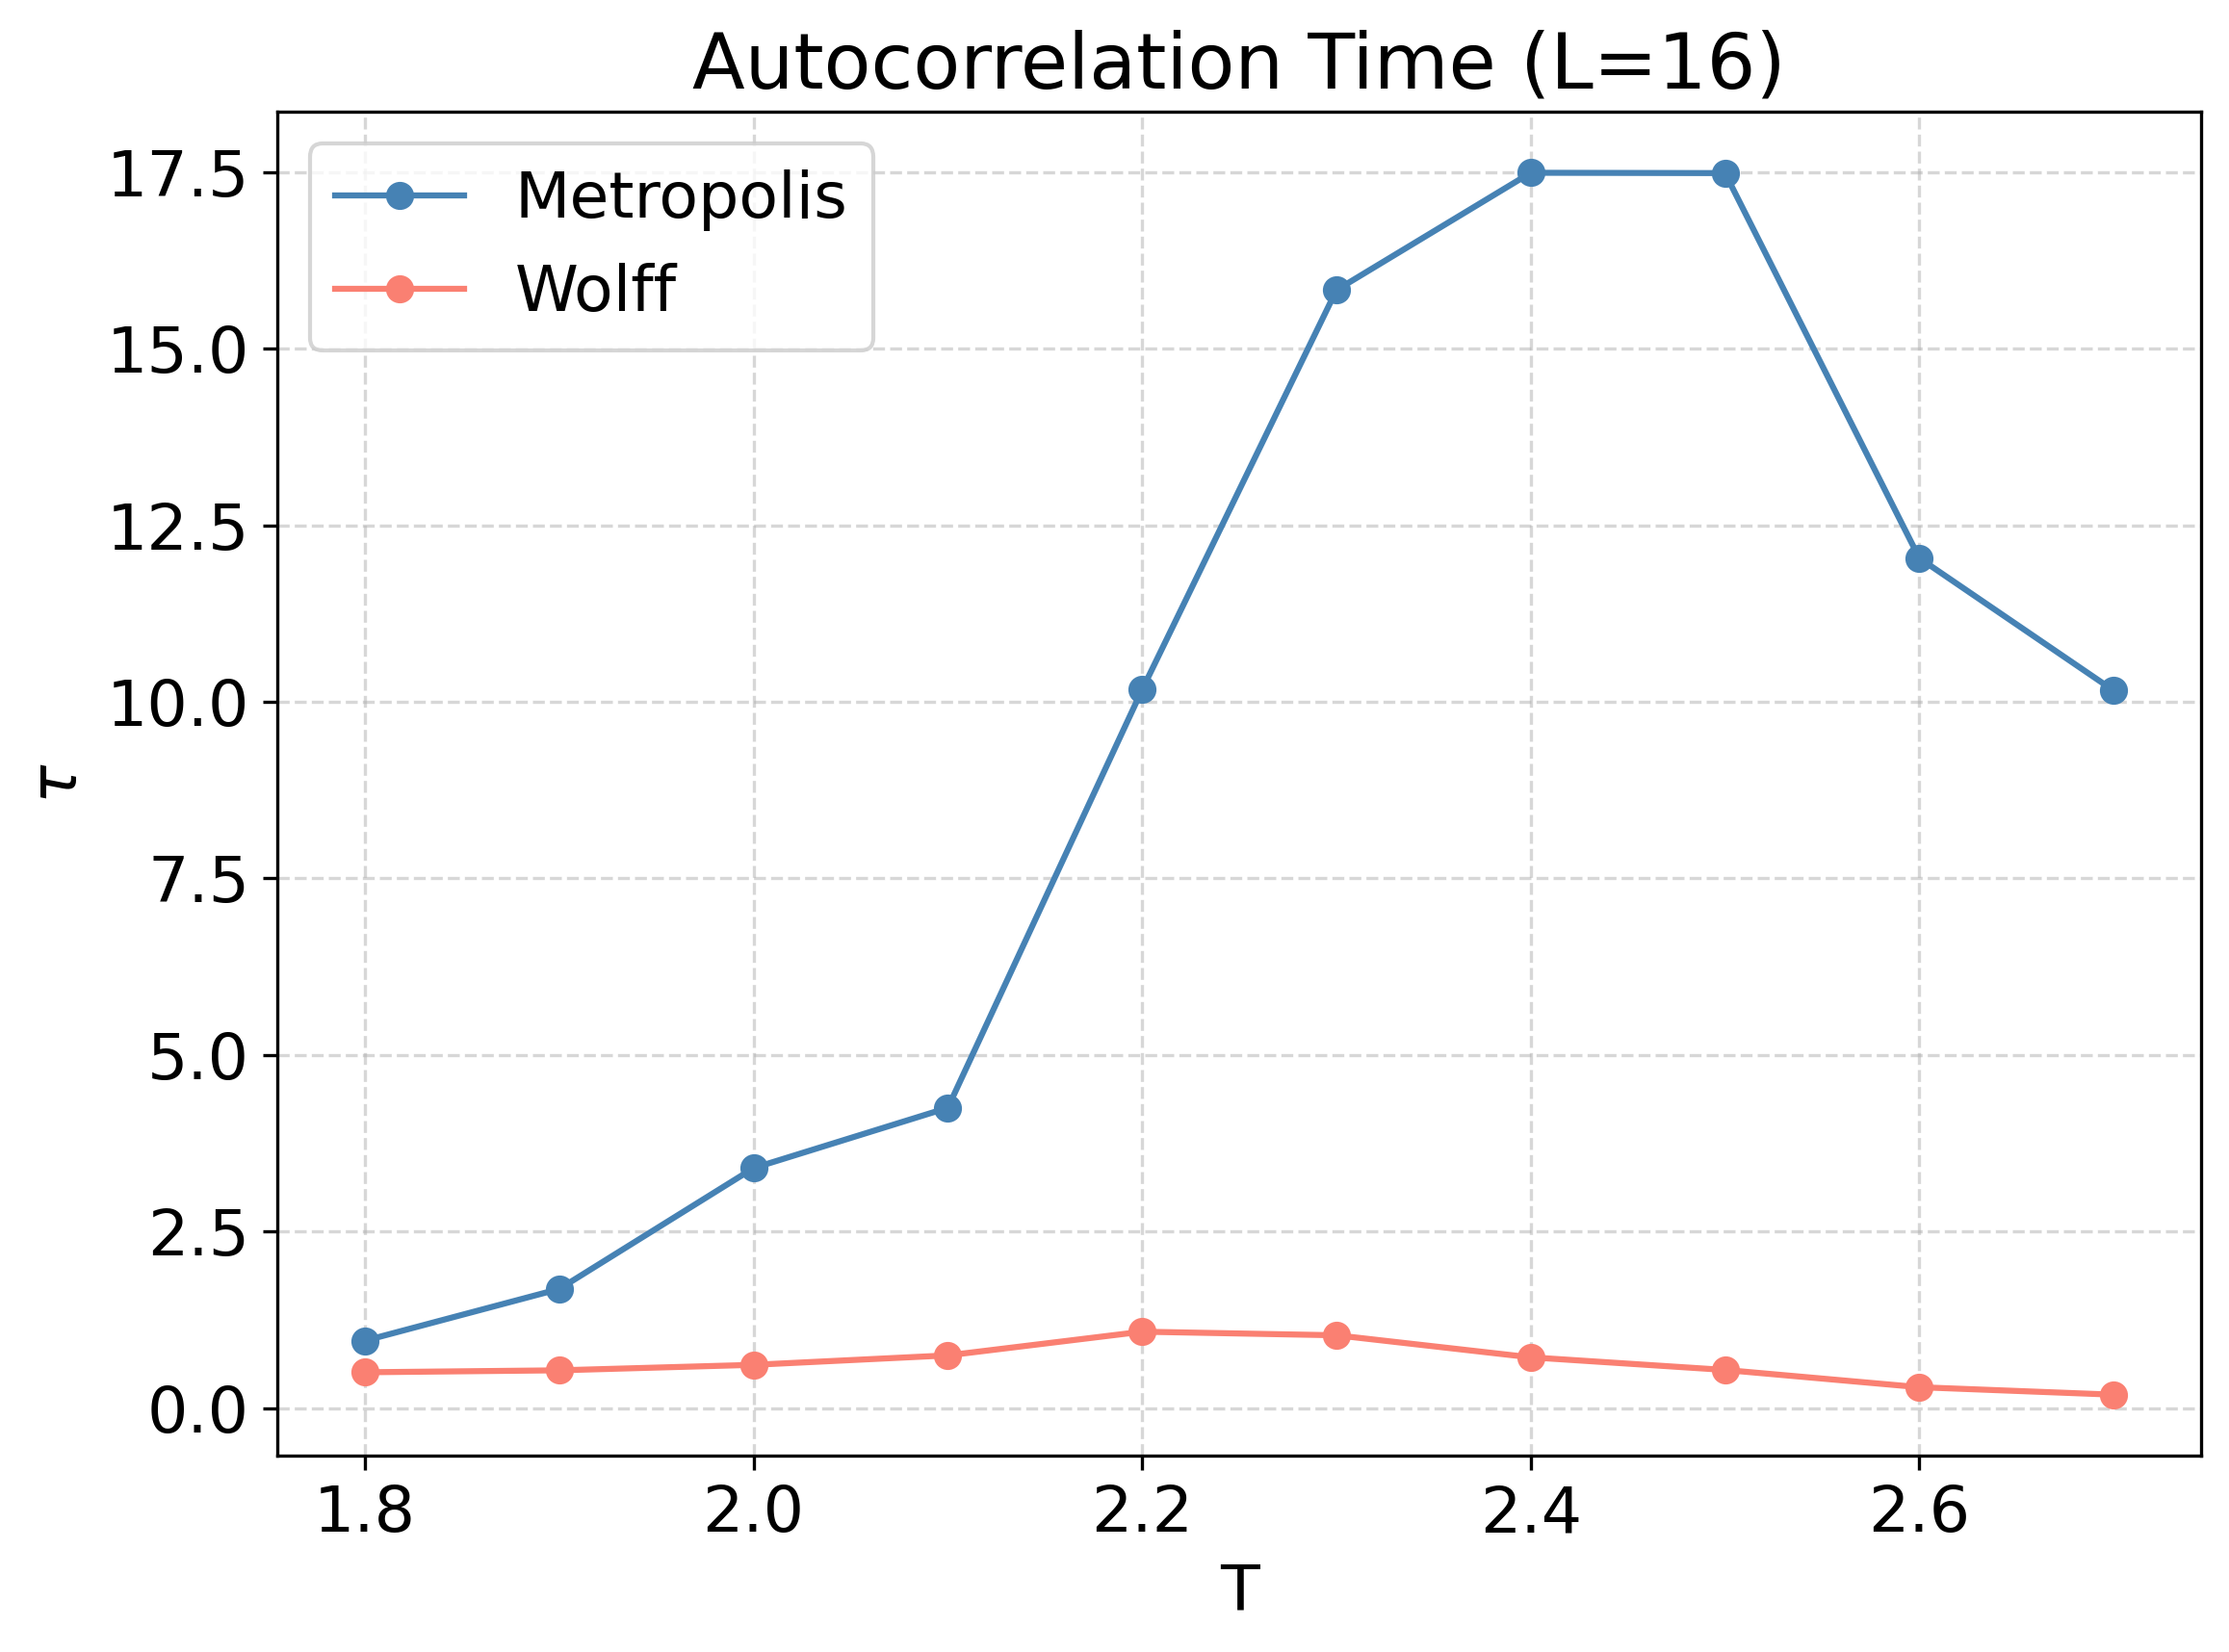

In [5]:
fig, ax = plt.subplots(figsize=(8,6),dpi=300)
ax.plot(T, np.array(tau_metro), 'o-', label='Metropolis', color='steelblue')
ax.plot(T, np.array(tau_wolff)*np.array(cluster_sizes)/(L*L), 'o-', label='Wolff', color='salmon')
ax.set_xlabel('T')
ax.set_ylabel(r'$\tau$') 
ax.set_title(f'Autocorrelation Time (L={L})')
ax.legend()
ax.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

As can be seen from the figure above, when the temperature is close to the critical temperature, $\tau_{\text{metro}}$ increases, while $\tau_{\text{wolff}}$ remains at a very small value.

## Simple Comparison

In the simulations below, we take $100\tau$ as the thermalization steps, $3000\tau$ as the measurement steps, sampling every $\tau$ steps.


In [6]:
L = 16
T = np.arange(1.8, 2.8, 0.1)

data_metro = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
}

data_wolff = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
    'cluster_size': [],
}

# ---- metropolis simulation ----#
pbar = tqdm(T, desc='Metropolis')
for t in pbar:
    i = np.where(T == t)[0][0]
    steps_metro_themal = int(100 * tau_metro[i] * L * L)
    steps_metro = int(3000 * tau_metro[i] * L * L)

    s = IsingSpins(L, L, J_val)
    e_sam, m_sam, _ = sim_ising(s, k_B * t, steps_metro_themal, steps_metro, 'metropolis', int(tau_metro[i]*L*L))
    data_metro['energy'].append(np.mean(e_sam))
    data_metro['energy_std'].append(np.std(e_sam))
    data_metro['magnetization'].append(np.mean(m_sam))
    data_metro['magnetization_std'].append(np.std(m_sam))
pbar.close()

# ---- wolff simulation ----#
pbar = tqdm(T, desc='Wolff')
for t in pbar:
    i = np.where(T == t)[0][0]

    steps_wolff_thermal = int(100 * tau_wolff[i])
    steps_wolff = int(3000 * tau_wolff[i]) 

    s_w = IsingSpins(L, L, J_val)
    e_sam, m_sam, cluster_size = sim_ising(s_w, k_B * t, steps_wolff_thermal, steps_wolff, 'wolff', int(np.ceil(tau_wolff[i])))
    
    data_wolff['energy'].append(np.mean(e_sam))
    data_wolff['energy_std'].append(np.std(e_sam))
    data_wolff['magnetization'].append(np.mean(m_sam))
    data_wolff['magnetization_std'].append(np.std(m_sam))
    data_wolff['cluster_size'].append(cluster_size)
pbar.close()

Wolff: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


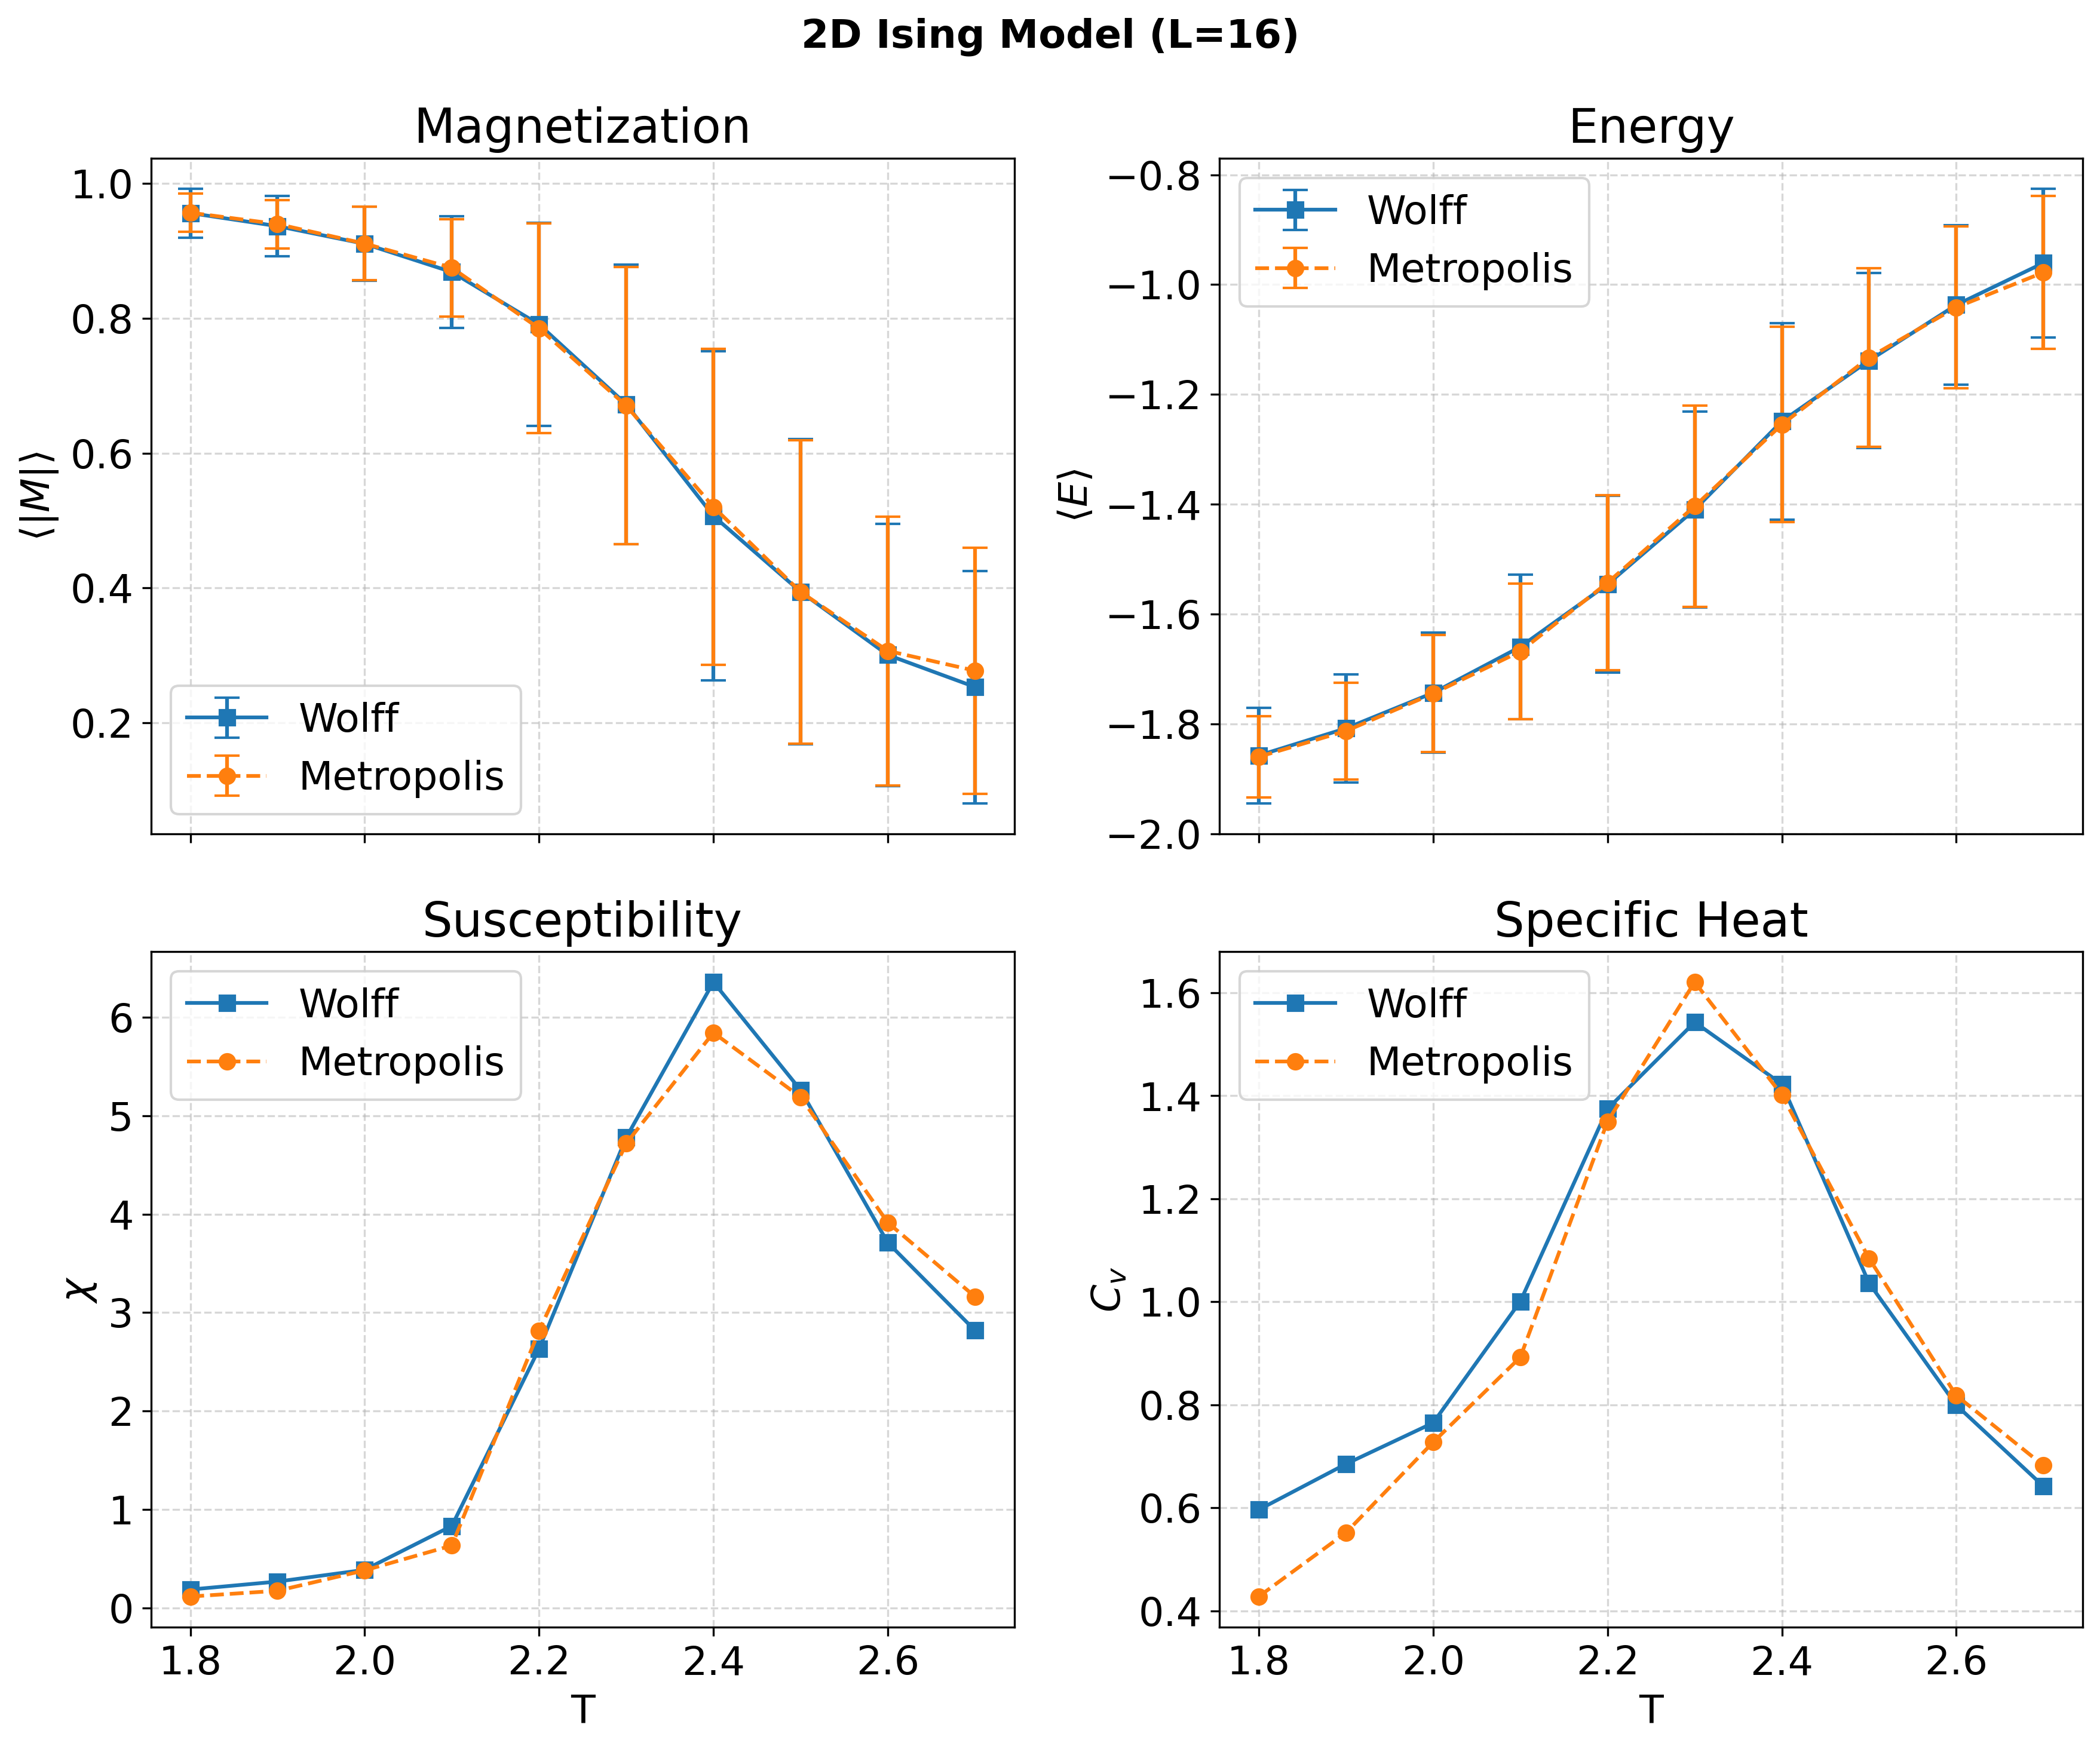

In [7]:
data_metro['T'] = T
data_metro['chi'] = L**2 * (np.array(data_metro['magnetization_std'])**2) / (k_B * T)
data_metro['Cv'] = L**2 * (np.array(data_metro['energy_std'])**2) / (k_B * T**2)
data_wolff['T'] = T
data_wolff['chi'] = L**2 * (np.array(data_wolff['magnetization_std'])**2) / (k_B * T)
data_wolff['Cv'] = L**2 * (np.array(data_wolff['energy_std'])**2) / (k_B * T**2)

fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=300, sharex=True)
axs[0, 0].errorbar(data_wolff['T'], data_wolff['magnetization'], yerr=data_wolff['magnetization_std'], label='Wolff', fmt='s-', capsize=5)
axs[0, 0].errorbar(data_metro['T'], data_metro['magnetization'], yerr=data_metro['magnetization_std'], label='Metropolis', fmt='o--', capsize=5)
axs[0, 0].set_ylabel(r'$\langle |M| \rangle$')
axs[0, 0].set_title('Magnetization')
axs[0, 0].grid(ls='--', alpha=0.5)
axs[0, 0].legend()

axs[0, 1].errorbar(data_wolff['T'], data_wolff['energy'], yerr=data_wolff['energy_std'], label='Wolff', fmt='s-', capsize=5)
axs[0, 1].errorbar(data_metro['T'], data_metro['energy'], yerr=data_metro['energy_std'], label='Metropolis', fmt='o--', capsize=5)
axs[0, 1].set_ylabel(r'$\langle E \rangle$')
axs[0, 1].set_title('Energy')
axs[0, 1].grid(ls='--', alpha=0.5)
axs[0, 1].legend()


axs[1, 0].plot(data_wolff['T'], data_wolff['chi'], 's-', label='Wolff')
axs[1, 0].plot(data_metro['T'], data_metro['chi'], 'o--', label='Metropolis')
axs[1, 0].set_xlabel('T')
axs[1, 0].set_ylabel(r'$\chi$')
axs[1, 0].set_title('Susceptibility')
axs[1, 0].grid(ls='--', alpha=0.5)
axs[1, 0].legend()

axs[1, 1].plot(data_wolff['T'], data_wolff['Cv'], 's-', label='Wolff')
axs[1, 1].plot(data_metro['T'], data_metro['Cv'], 'o--', label='Metropolis')
axs[1, 1].set_xlabel('T')
axs[1, 1].set_ylabel(r'$C_v$')
axs[1, 1].set_title('Specific Heat')
axs[1, 1].grid(ls='--', alpha=0.5)
axs[1, 1].legend()

fig.suptitle(f'2D Ising Model (L={L})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

The curves obtained by the two algorithms align well, confirming the correctness of our Wolff implementation.

## Scaling Law and Critical Exponents

The finite-size scaling theroy gives (around $T_c$):
| Statistic Quantity | Scaling Relation | Critical Exponent (2D) |
|-------------------|------------------|-------------------|
| Magnetization: $m$ | $m \sim L^{-\beta/\nu}$ | $\beta = 1/8$ |
| Specific Heat: $C_V$ | $C_V \sim L^{\alpha/\nu}$ | $\alpha = 0$ (logarithmic) |
| Magnetic Susceptibility: $\chi$ | $\chi \sim L^{\gamma/\nu}$ | $\gamma = 7/4$ |
| Connected Correlation Function: $\langle c \rangle$ | $\langle c \rangle \sim L^{\gamma/\nu}$ | $\gamma = 7/4$ |
| Correlation Length: $\tau$ | $\tau \sim L^{z}$ | different from algorithms |

In [5]:
L = np.array([4, 6, 9, 12, 16, 24, 32, 48])
Tc = 2/np.log(1 + np.sqrt(2))
print(f'Critical Temperature: {Tc:.4f}')

Critical Temperature: 2.2692


Similarly, we first estimate the autocorrelation time $\tau$ at $T_c$ for different system sizes.

In [6]:
tau_wolff_L = []
tau_metro_L = []
cluster_sizes_L = []

# we only compute metropolis upto L=32 due to long autocorrelation time
pbar = tqdm(L, desc="Metropolis")
for l in pbar:
    tau_metro_val = 0
    for _ in range(30):  # repeat to avoid outliers
        s = IsingSpins(l, l, J_val)
        steps_metro_thermal = 300 * l **2
        steps_metro = 900 * l **2
        e_samples, m_samples, _ = sim_ising(s, Tc, steps_metro_thermal, steps_metro, method="metropolis", lag=l**2)
        acf_metro = autocorr_func(m_samples)
        tau_metro_val += integrated_autocorr_time(acf_metro)
    tau_metro_L.append(tau_metro_val/30)
pbar.close()

pbar = tqdm(L, desc="Wolff")
for l in pbar:
    tau_wolff_val = 0
    cluster_size_val = 0
    for _ in range(30):  # repeat to avoid outliers
        s = IsingSpins(l, l, J_val)
        steps_wolff_thermal = 300
        steps_wolff = 500
        e_samples, m_samples, cluster_size = sim_ising(s, Tc, steps_wolff_thermal, steps_wolff, method="wolff", lag=1)
        acf_wolff = autocorr_func(m_samples)
        tau_wolff_val += integrated_autocorr_time(acf_wolff)
        cluster_size_val += cluster_size
    tau_wolff_L.append(tau_wolff_val/30)
    cluster_sizes_L.append(cluster_size_val/30)
pbar.close()

print('tau_metropolis:\n', np.round(tau_metro_L, 3))
print('tau_wolff:\n', np.round(tau_wolff_L, 3))
print('cluster_sizes:\n', np.round(cluster_sizes_L, 3))


Metropolis:   0%|          | 0/8 [00:00<?, ?it/s]

Wolff: 100%|██████████| 8/8 [00:25<00:00,  3.16s/it]

tau_metropolis:
 [ 2.899  5.607 11.85  18.518 26.217 41.755 57.438 74.359]
tau_wolff:
 [1.04  1.316 1.615 2.174 2.193 2.68  3.206 3.557]
cluster_sizes:
 [ 11.6    24.467  50.7    84.633 141.667 290.033 466.067 941.6  ]


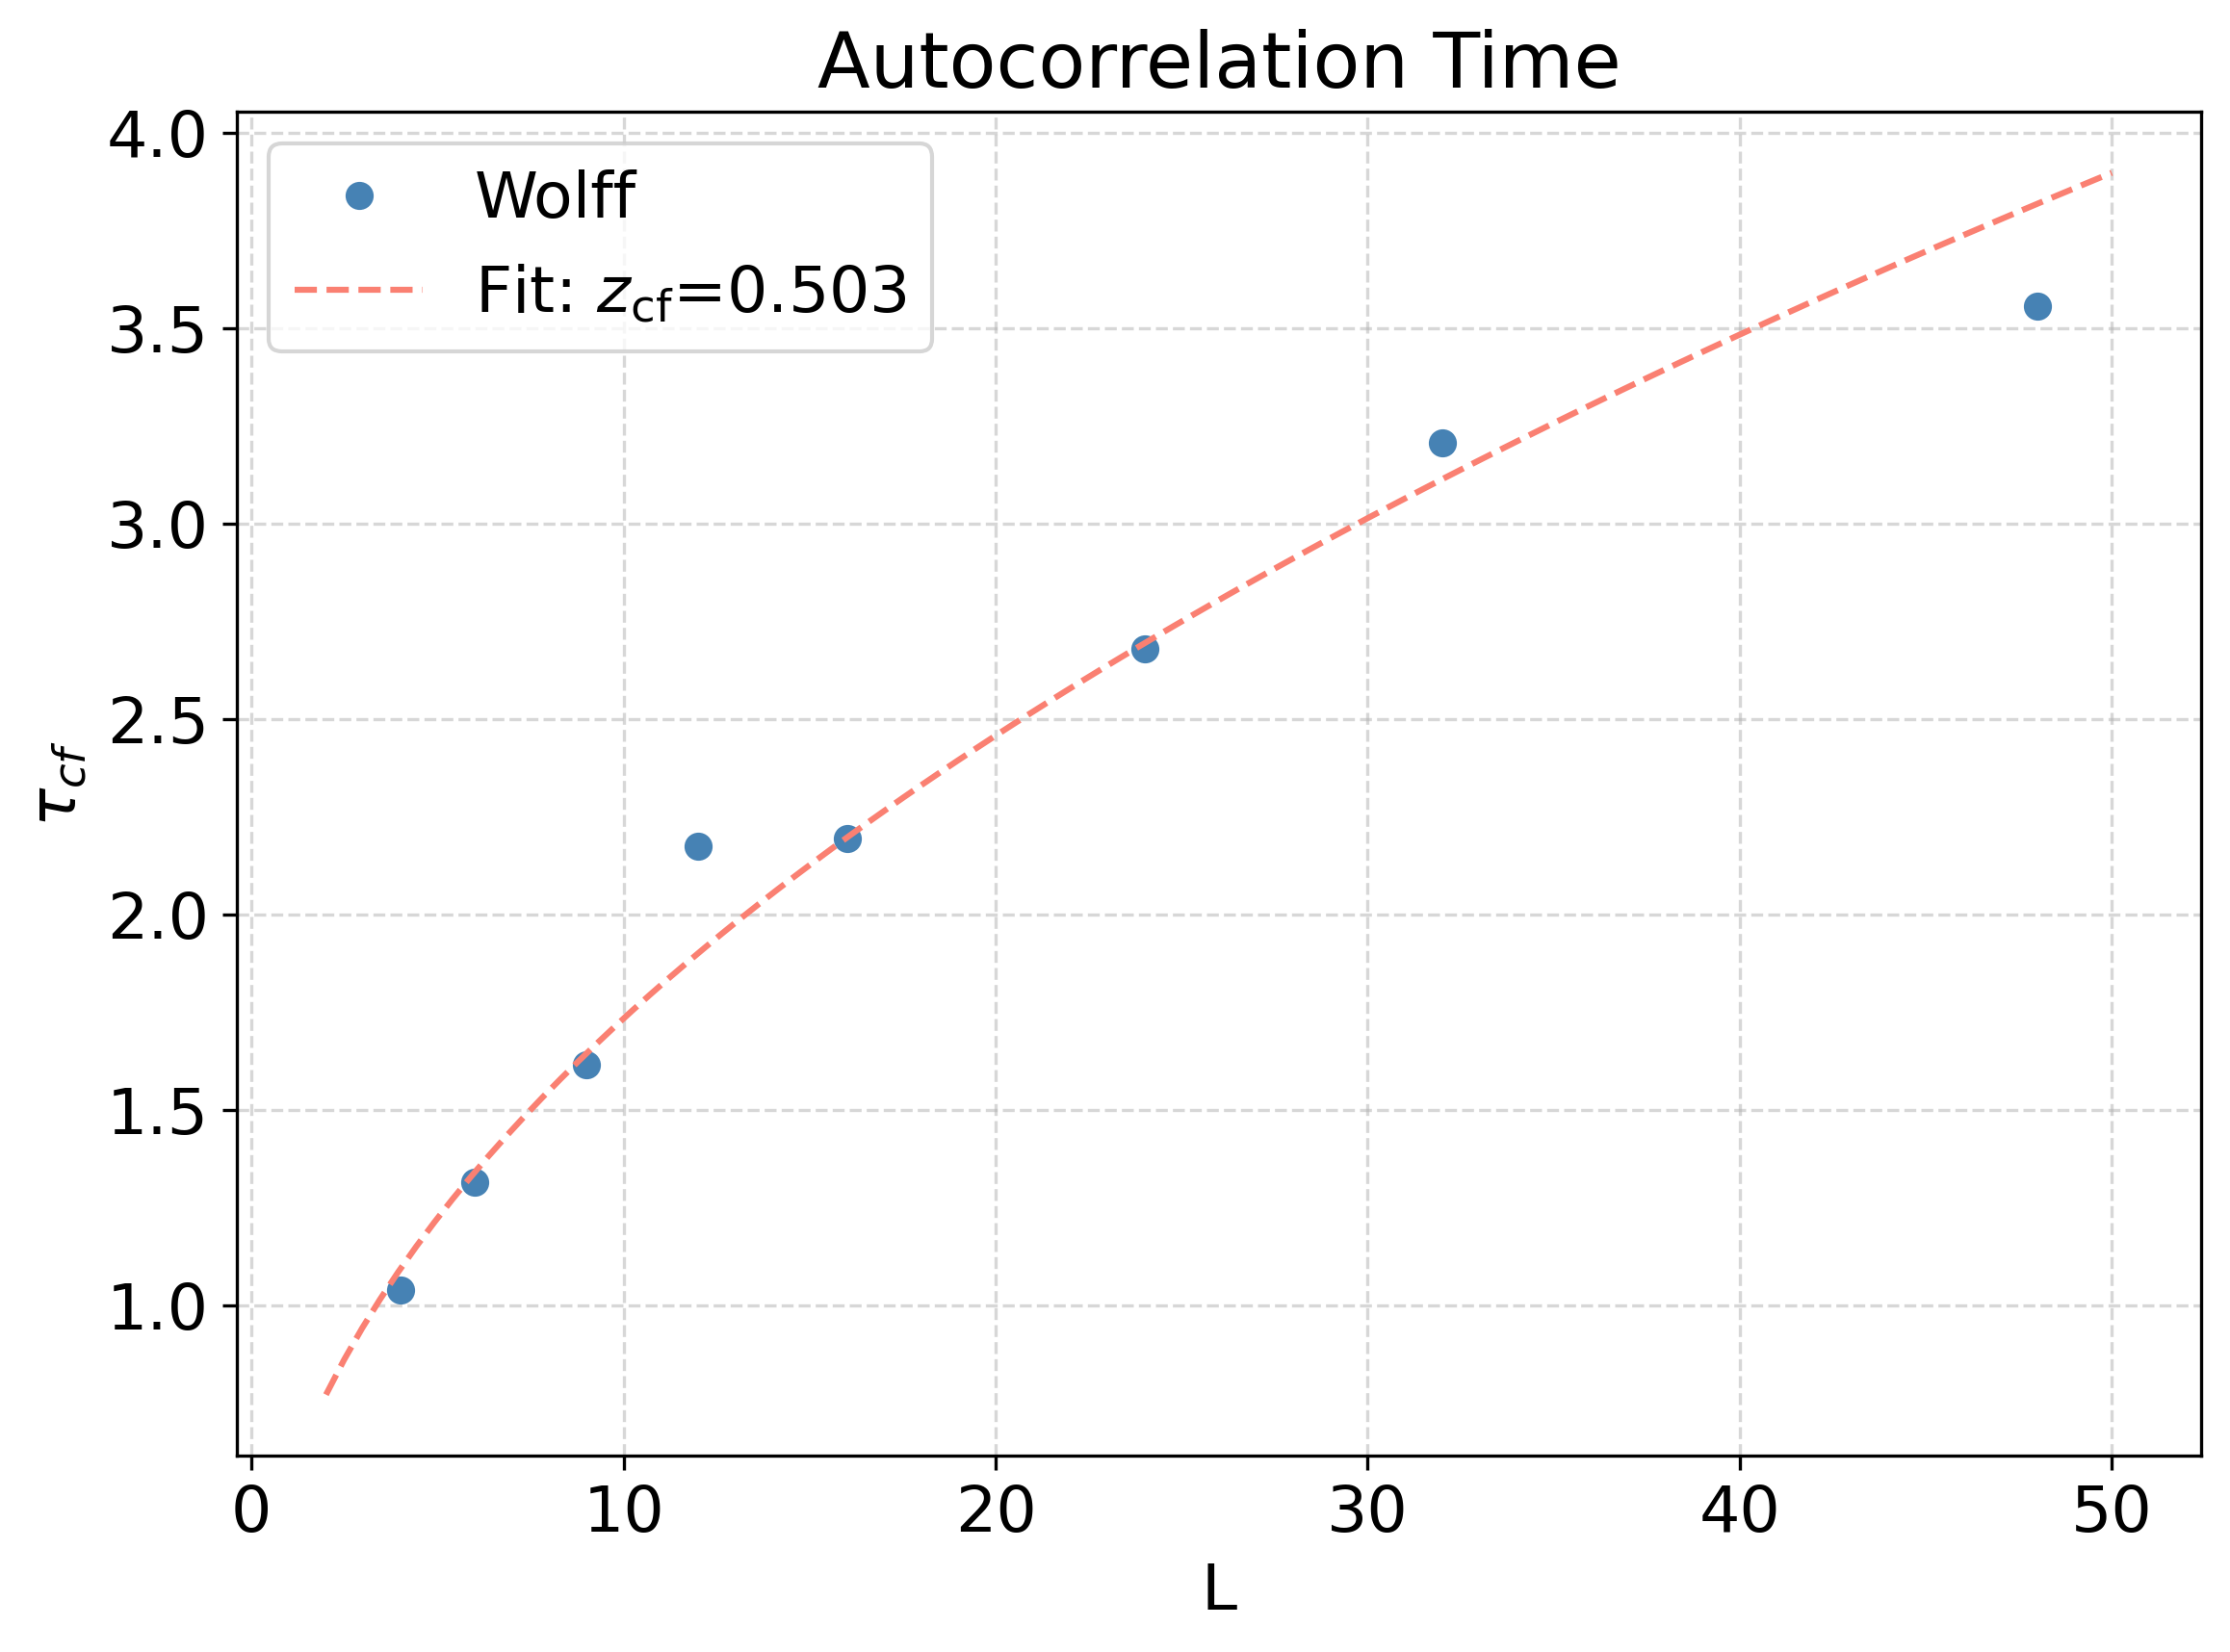

In [7]:
zcf, inter_zcf = np.polyfit(np.log(L), np.log(np.array(tau_wolff_L)), 1)

L_fit = np.linspace(2, 50, 100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
ax.plot(L, tau_wolff_L, 'o', label='Wolff', color='steelblue')
ax.plot(L_fit, np.exp(inter_zcf) * L_fit**zcf, '--', label=fr'Fit: $z_{{\text{{cf}}}}$={zcf:.3f}', color='salmon')
ax.set_xlabel('L')
ax.set_ylabel(r'$\tau_{cf}$')
ax.set_title('Autocorrelation Time')
ax.grid(ls='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

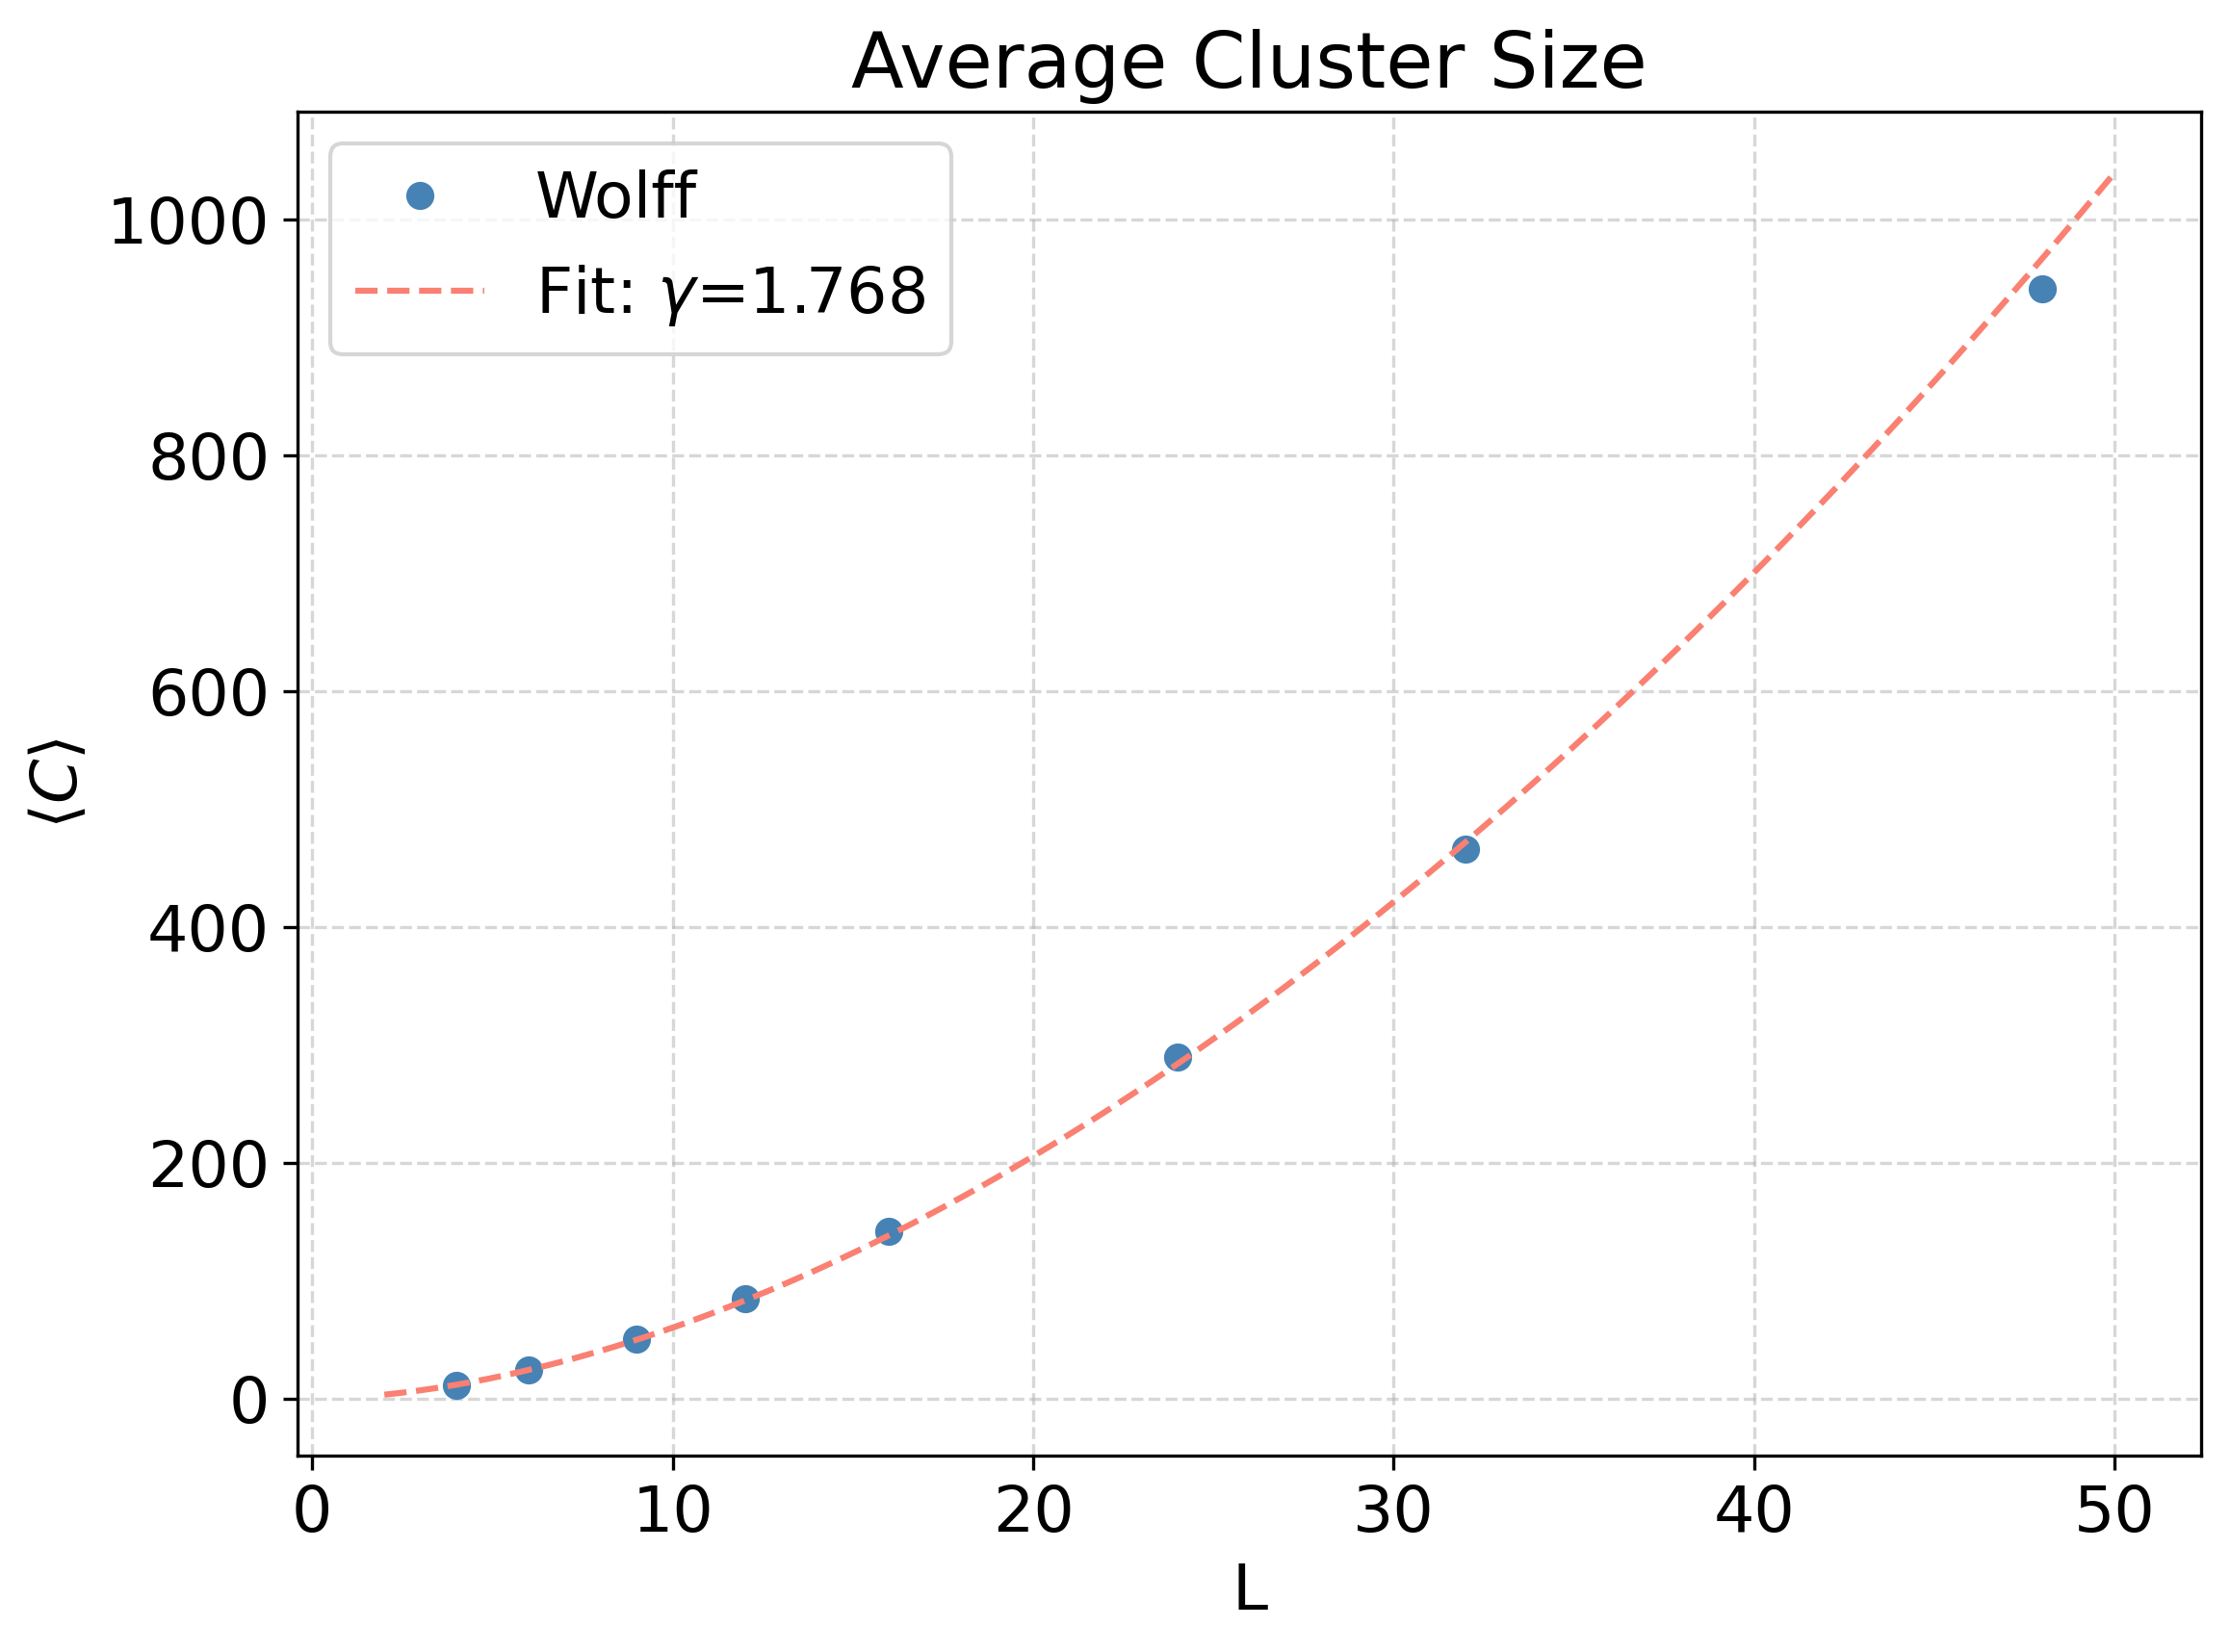

In [8]:
gamma_c, inter_gc = np.polyfit(np.log(L), np.log(cluster_sizes_L), 1)

L_fit = np.linspace(2, 50, 100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
ax.plot(L, cluster_sizes_L, 'o', label='Wolff', color='steelblue')
ax.plot(L_fit, np.exp(inter_gc) * L_fit**gamma_c, '--', label=r'Fit: $\gamma$={:.3f}'.format(gamma_c), color='salmon')
ax.set_xlabel('L')
ax.set_ylabel(r'$\langle C \rangle$')
ax.set_title('Average Cluster Size')
ax.grid(ls='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

$$\tau_{\text{wolff}} = \tau_{\text{cf}} \times \frac{\langle \text{c} \rangle}{L^2}$$

Critical exponent z (Metropolis): 1.329
Critical exponent z (Wolff): 0.272


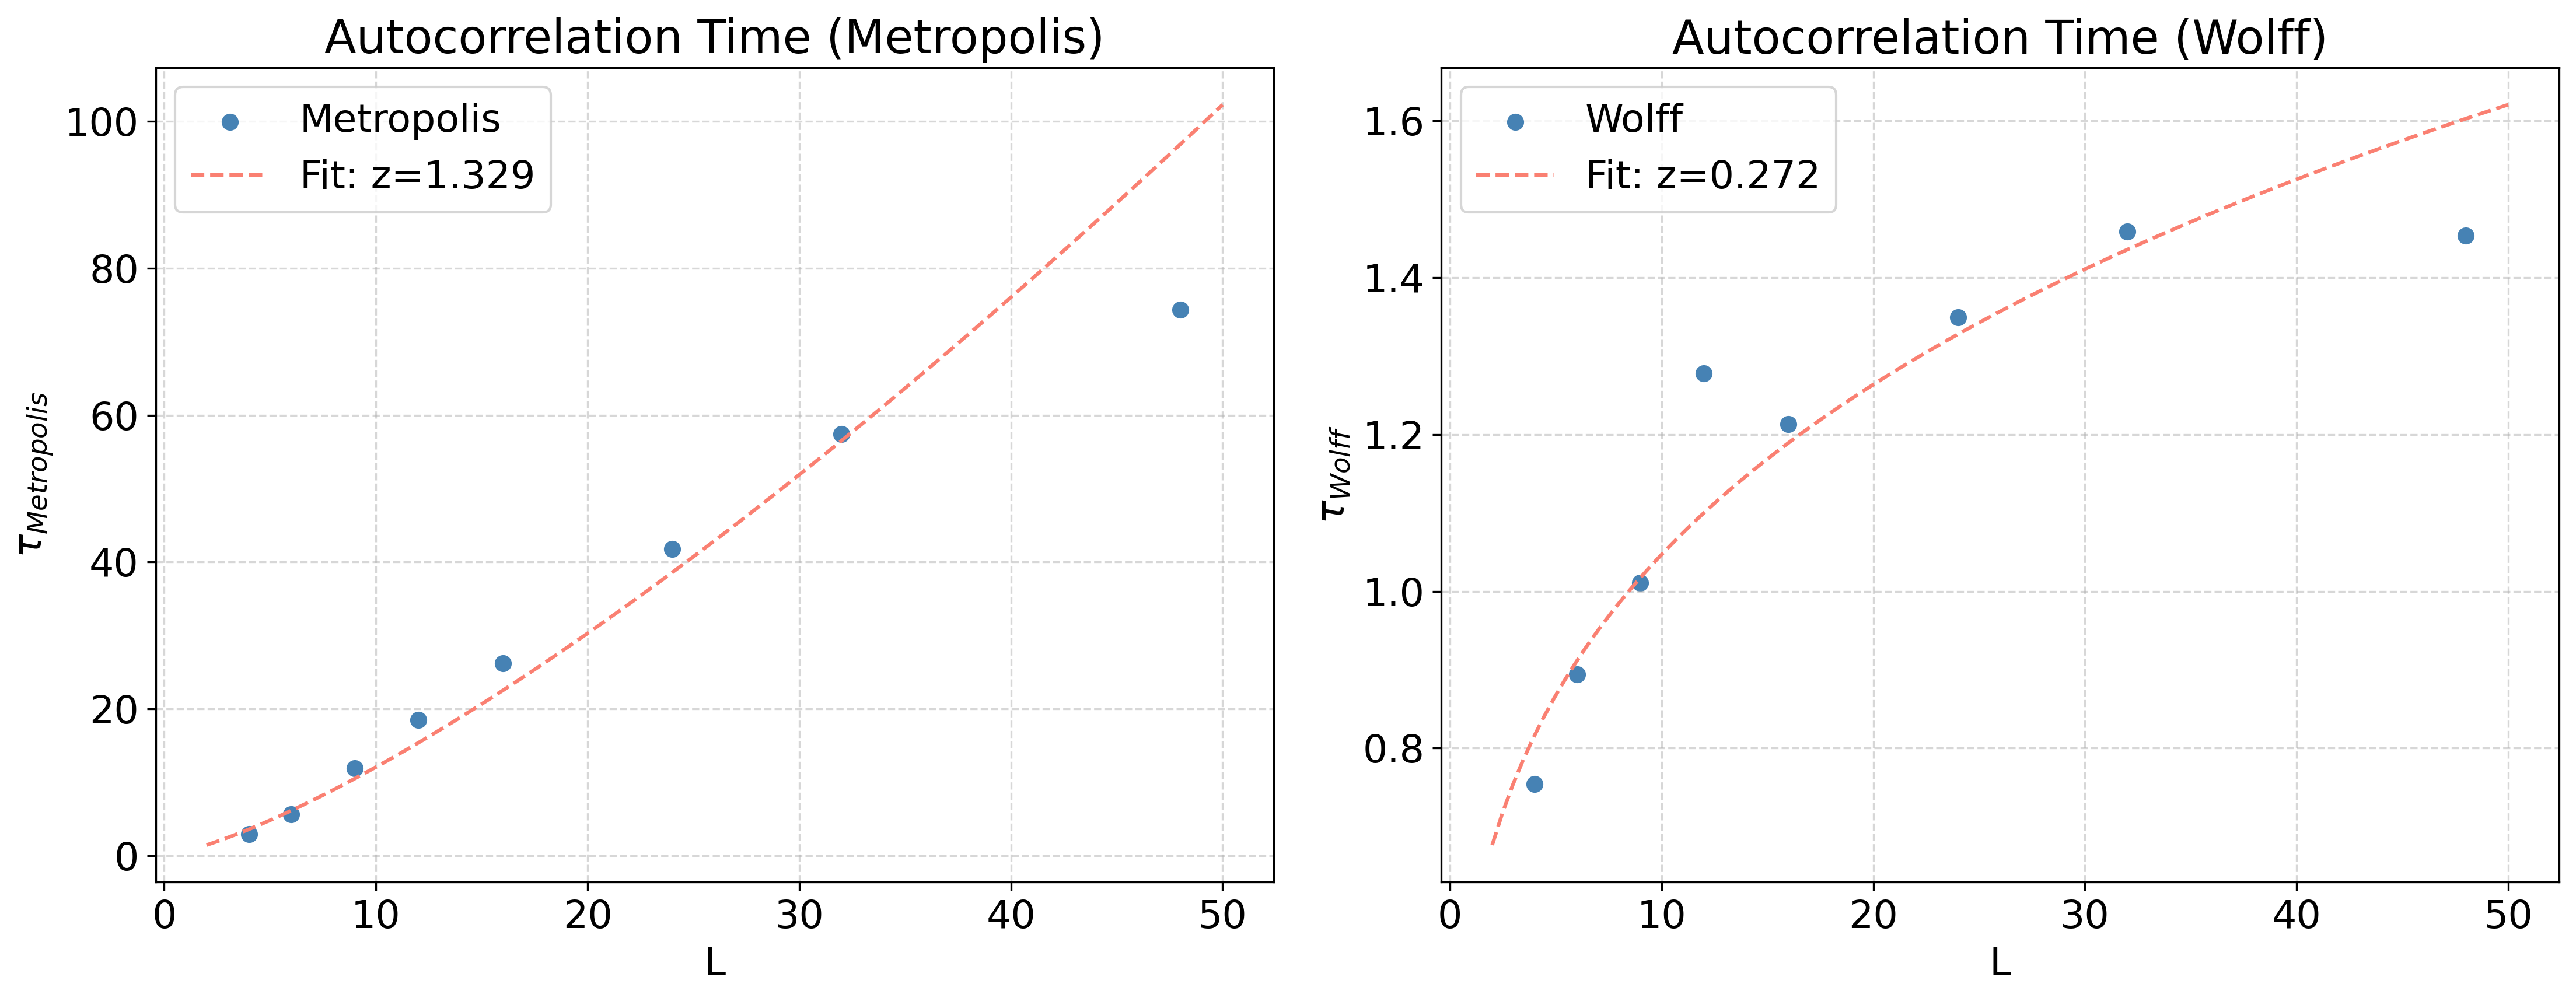

In [9]:
z_metro,inter_zm = np.polyfit(np.log(L), np.log(tau_metro_L), 1)
z_wolff, inter_zw = np.polyfit(np.log(L), np.log(np.array(tau_wolff_L)*np.array(cluster_sizes_L)/np.array(L)**2), 1)

print(f'Critical exponent z (Metropolis): {z_metro:.3f}')
print(f'Critical exponent z (Wolff): {z_wolff:.3f}')

L_fit = np.linspace(2, 50, 100)
fig, ax = plt.subplots(1,2, figsize=(15,6),dpi=300)
ax[0].scatter(L, tau_metro_L, label='Metropolis', color='steelblue')
ax[0].plot(L_fit, np.exp(inter_zm) * L_fit**z_metro, '--', label='Fit: z={:.3f}'.format(z_metro), color='salmon')
ax[0].set_xlabel('L') 
ax[0].set_ylabel(r'$\tau_{Metropolis}$')
ax[0].set_title('Autocorrelation Time (Metropolis)')
ax[0].grid(ls='--', alpha=0.5)
ax[0].legend()
ax[1].scatter(L, np.array(tau_wolff_L)*np.array(cluster_sizes_L)/np.array(L)**2, label='Wolff', color='steelblue')
ax[1].plot(L_fit, np.exp(inter_zw) * L_fit**z_wolff, '--', label='Fit: z={:.3f}'.format(z_wolff), color='salmon')
ax[1].set_xlabel('L')
ax[1].set_ylabel(r'$\tau_{Wolff}$')
ax[1].set_title('Autocorrelation Time (Wolff)')
ax[1].grid(ls='--', alpha=0.5)
ax[1].legend()
plt.tight_layout()
plt.show()

Estimated dynamic critical exponent $z$ of Metropolis algorithm smaller than the theoretical value $2.167$, probably due to finite-size effects.

In [10]:
data_metro_L = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
}

data_wolff_L = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
    'cluster_size': [],
}

#---- metropolis simulation ----#
pbar = tqdm(L, desc='Metropolis')
for l in pbar:
    i = np.where(L == l)[0][0]
    cluster_size = cluster_sizes_L[i]

    steps_metro_thermal = int(100 * tau_metro_L[i])
    steps_metro = int(3000 * tau_metro_L[i] * l * l)

    s = IsingSpins(l, l, J_val)
    e_sam, m_sam, _ = sim_ising(s, k_B * Tc, steps_metro_thermal, steps_metro, 'metropolis', int(tau_metro_L[i]*l*l))
    data_metro_L['energy'].append(np.mean(e_sam))
    data_metro_L['energy_std'].append(np.std(e_sam))
    data_metro_L['magnetization'].append(np.mean(m_sam))
    data_metro_L['magnetization_std'].append(np.std(m_sam))
pbar.close()

#---- wolff simulation ----#
pbar = tqdm(L, desc='Wolff')
for l in pbar:
    i = np.where(L == l)[0][0]

    steps_wolff_thermal = int(100 * tau_wolff_L[i])
    steps_wolff = int(3000 * tau_wolff_L[i])

    s_w = IsingSpins(l, l, J_val)
    e_sam, m_sam, cluster_size = sim_ising(s_w, k_B * Tc, steps_wolff_thermal, steps_wolff, 'wolff', int(tau_wolff_L[i]))
    
    data_wolff_L['energy'].append(np.mean(e_sam))
    data_wolff_L['energy_std'].append(np.std(e_sam))
    data_wolff_L['magnetization'].append(np.mean(m_sam))
    data_wolff_L['magnetization_std'].append(np.std(m_sam))
    data_wolff_L['cluster_size'].append(cluster_size)
pbar.close()

data_metro_L['L'] = L
data_metro_L['chi'] = L**2 * (np.array(data_metro_L['magnetization_std'])**2) / (k_B * Tc)
data_metro_L['Cv'] = L**2 * (np.array(data_metro_L['energy_std'])**2) / (k_B * Tc**2)

data_wolff_L['L'] = L
data_wolff_L['chi'] = L**2 * (np.array(data_wolff_L['magnetization_std'])**2) / (k_B * Tc)
data_wolff_L['Cv'] = L**2 * (np.array(data_wolff_L['energy_std'])**2) / (k_B * Tc**2)

Wolff: 100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Take $\nu$ as the exact value $1$, we can fit the critical exponents $\beta$, $\gamma$, and $\alpha$ from the datas.

,Method,Beta,Gamma,C0
0,Metropolis,0.124601,1.789098,0.535874
1,Wolff,0.121860,1.756643,0.511866
2,Exact,0.125000,1.750000,0.500000


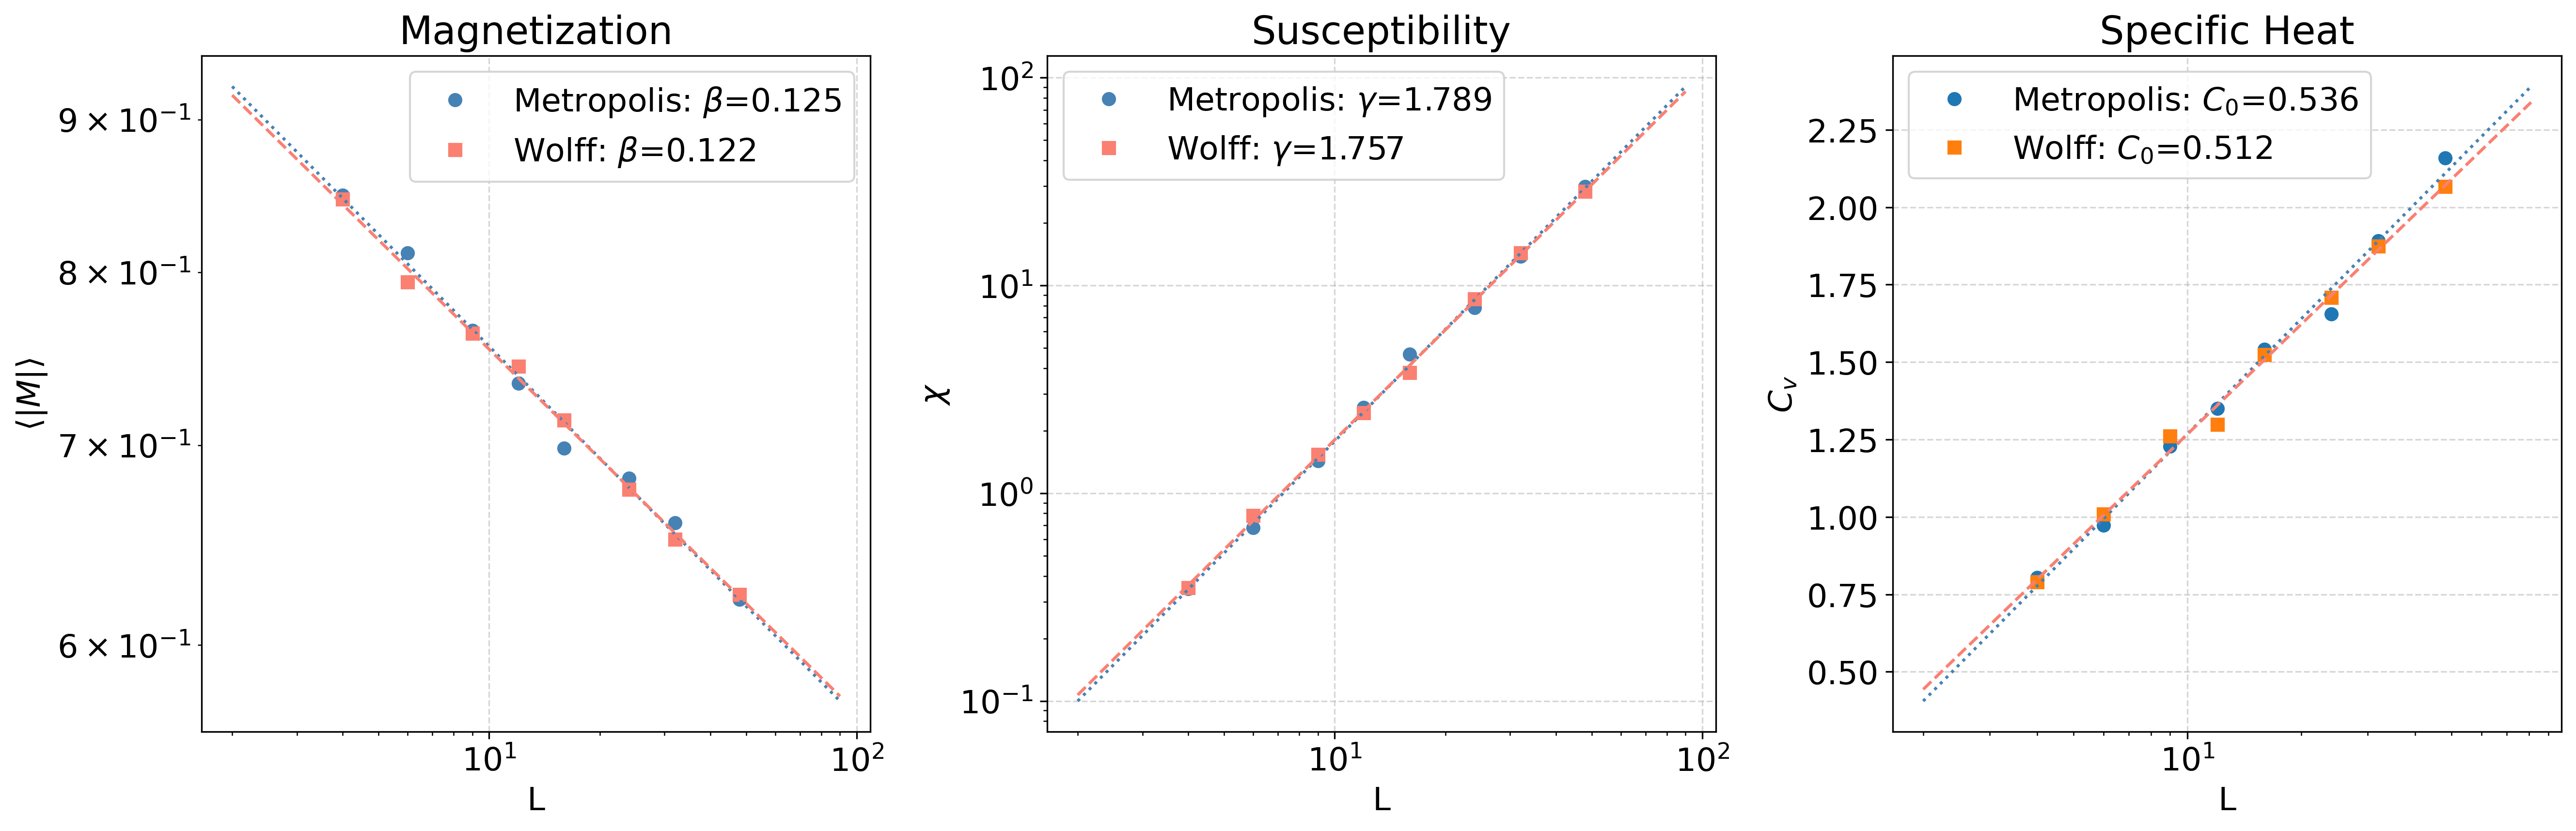

In [11]:
# beta
beta_metro, intercept_beta_metro = np.polyfit(np.log(L), np.log(data_metro_L['magnetization']), 1)
beta_wolff, intercept_beta_wolff = np.polyfit(np.log(L), np.log(data_wolff_L['magnetization']), 1)

# gamma
gamma_metro, intercept_gamma_metro = np.polyfit(np.log(L), np.log(data_metro_L['chi']), 1)
gamma_wolff, intercept_gamma_wolff = np.polyfit(np.log(L), np.log(data_wolff_L['chi']), 1)

# alpha = 0
C0_metro, intercept_C0_metro = np.polyfit(np.log(L), data_metro_L['Cv'], 1)
C0_wolff, intercept_C0_wolff = np.polyfit(np.log(L), data_wolff_L['Cv'], 1)

df_scaling = pd.DataFrame({
    'Method': ['Metropolis', 'Wolff', 'Exact'],
    'Beta': [-beta_metro, -beta_wolff, 0.125],
    'Gamma': [gamma_metro, gamma_wolff, 1.75],
    'C0': [C0_metro, C0_wolff, 0.5],
})

display(df_scaling)

L_fit = np.linspace(2, 90, 100)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=300)
axs[0].loglog(L, data_metro_L['magnetization'], 'o', label=r'Metropolis: $\beta$={:.3f}'.format(-beta_metro),color='steelblue')
axs[0].loglog(L, data_wolff_L['magnetization'], 's', label=r'Wolff: $\beta$={:.3f}'.format(-beta_wolff),color='salmon')
axs[0].loglog(L_fit, np.exp(intercept_beta_metro) * L_fit**beta_metro, ':',color='steelblue')
axs[0].loglog(L_fit, np.exp(intercept_beta_wolff) * L_fit**beta_wolff, '--',color='salmon')
axs[0].set_xlabel('L')
axs[0].set_ylabel(r'$\langle |M| \rangle$')
axs[0].set_title('Magnetization')
axs[0].grid(ls='--', alpha=0.5)
axs[0].legend()

axs[1].loglog(L, data_metro_L['chi'], 'o', label=r'Metropolis: $\gamma$={:.3f}'.format(gamma_metro),color='steelblue')
axs[1].loglog(L, data_wolff_L['chi'], 's', label=r'Wolff: $\gamma$={:.3f}'.format(gamma_wolff),color='salmon')
axs[1].loglog(L_fit, np.exp(intercept_gamma_metro) * L_fit**gamma_metro,':',color='steelblue')
axs[1].loglog(L_fit, np.exp(intercept_gamma_wolff) * L_fit**gamma_wolff, '--',color='salmon')
axs[1].set_xlabel('L')  
axs[1].set_ylabel(r'$\chi$')
axs[1].grid(ls='--', alpha=0.5)
axs[1].set_title('Susceptibility')
axs[1].legend()

axs[2].plot(L, data_metro_L['Cv'], 'o', label=r'Metropolis: $C_0$={:.3f}'.format(C0_metro))
axs[2].plot(L, data_wolff_L['Cv'], 's', label=r'Wolff: $C_0$={:.3f}'.format(C0_wolff))
axs[2].plot(L_fit[:90], C0_metro*np.log(L_fit[:90]) + intercept_C0_metro, ':', color='steelblue')
axs[2].plot(L_fit[:90], C0_wolff*np.log(L_fit[:90]) + intercept_C0_wolff, '--', color='salmon')
axs[2].set_xscale('log')
axs[2].set_xlabel('L')
axs[2].set_ylabel(r'$C_v$')
axs[2].grid(ls='--', alpha=0.5)
axs[2].set_title('Specific Heat')
axs[2].legend()
plt.tight_layout()
plt.show()

As shown in the plots below, the fitted critical exponents by two algorithms closely match the theoretical values.

There is a relationship between scaling exponents:

$$z=z_{\text{cf}}-(d-\gamma/\nu)$$

where $d$ is the spatial dimension (here $d=2$).

In [54]:
print(f'LHS: {z_wolff:.3f}')
print(f'RHS: {zcf - (2 - gamma_wolff/1):.3f}')

LHS: 0.272
RHS: 0.260


## Site-Bond Percolation Cluster

### Fisher Exponent

Wolff algorithm builds site-bond percolation clusters, which can be analyzed to extract percolation properties. The quantity will be used includes:
- Size: number of sites in the cluster
- $s\cdot n_s$: number of clusters of size $s$
- $n_s$: number of clusters normalized by total number of sites

For example, we counted $10$ clusters of $s=2$, then $n_s = 10 / 2 = 5$. This is because each site in a cluster of size $s$ has equal probability to be selected as the seed spin, thus a cluster of size $s$ can be generated in $s$ different ways and added to the total count by $s$ times. 

In [20]:
L_site = 128
T_c = 2 / np.log(1 + np.sqrt(2))

steps_wolff_thermal = 500
steps_wolff = 50000
cluster_sizes = dict()

s = IsingSpins(L_site, L_site, J_val)

for _ in range(steps_wolff_thermal):
    wolffStep(s, k_B * T_c)

for i in range(steps_wolff):
    cluster_set = wolffStep(s, k_B * T_c)
    size = len(cluster_set)
    if size in cluster_sizes:
        cluster_sizes[size] += 1
    else:
        cluster_sizes[size] = 1

cluster_sizes_items = sorted(cluster_sizes.items())
sizes = np.array([item[0] for item in cluster_sizes_items])
s_ns = np.array([item[1] for item in cluster_sizes_items])
ns = s_ns / sizes

The scaling law of $n_s$ at $T_c$ is given by:

$$n_s \sim s^{-\tau}\quad (s\gg 1)$$

where $\tau$ is the Fisher exponent. $\tau=187/91 \approx 2.19$ for 2D site-bond percolation.

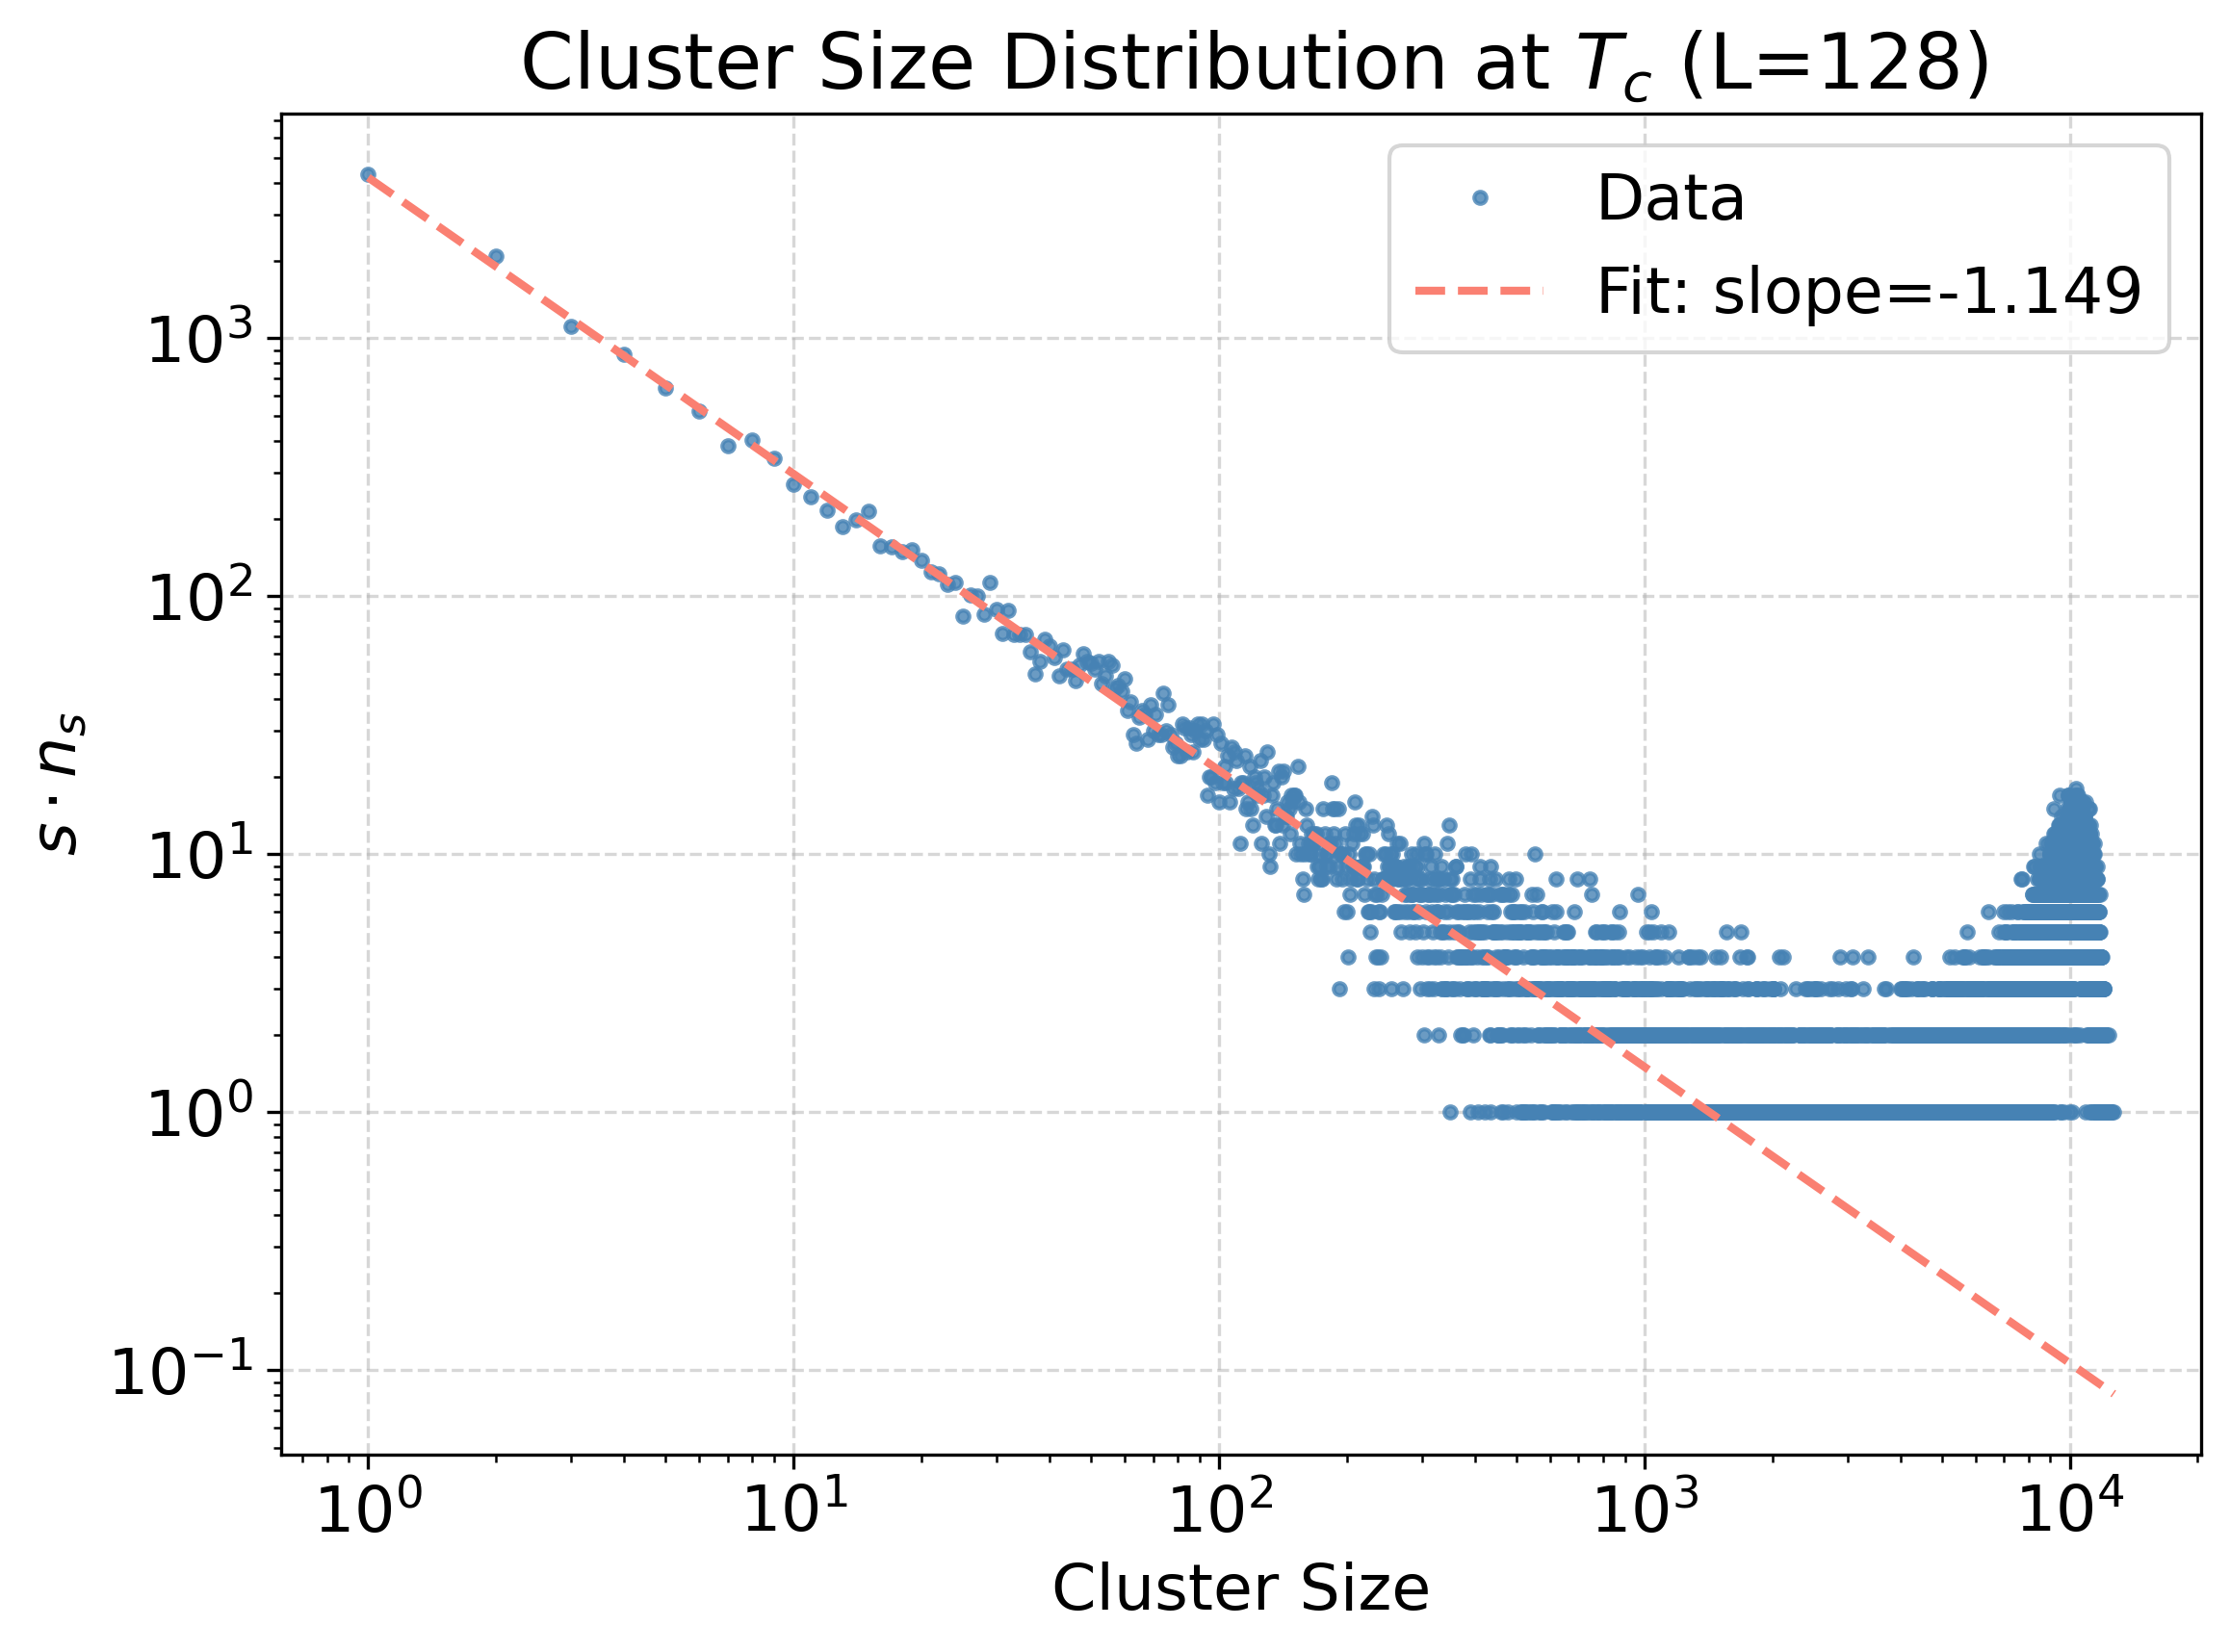

In [32]:
tau_sns, inter_tau_sns = np.polyfit(np.log(sizes[:L_site * 6]), np.log(s_ns[:L_site * 6]), 1)
s_fit = np.linspace(1, sizes[-1], 100)
s_ns_fit = np.exp(inter_tau_sns) * s_fit**tau_sns

fig, ax = plt.subplots(figsize=(8,6),dpi=300)
ax.loglog(sizes, s_ns, 'o', markersize=3, color='steelblue', label='Data', alpha=0.8)
ax.loglog(s_fit, s_ns_fit, '--', lw=2, color='salmon', label=r'Fit: slope={:.3f}'.format(tau_sns))
ax.set_xlabel('Cluster Size')
ax.set_ylabel(r'$s\cdot n_s$')
ax.set_title(rf' Cluster Size Distribution at $T_c$ (L={L_site})')
ax.legend()
ax.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

Fisher exponent: 2.149


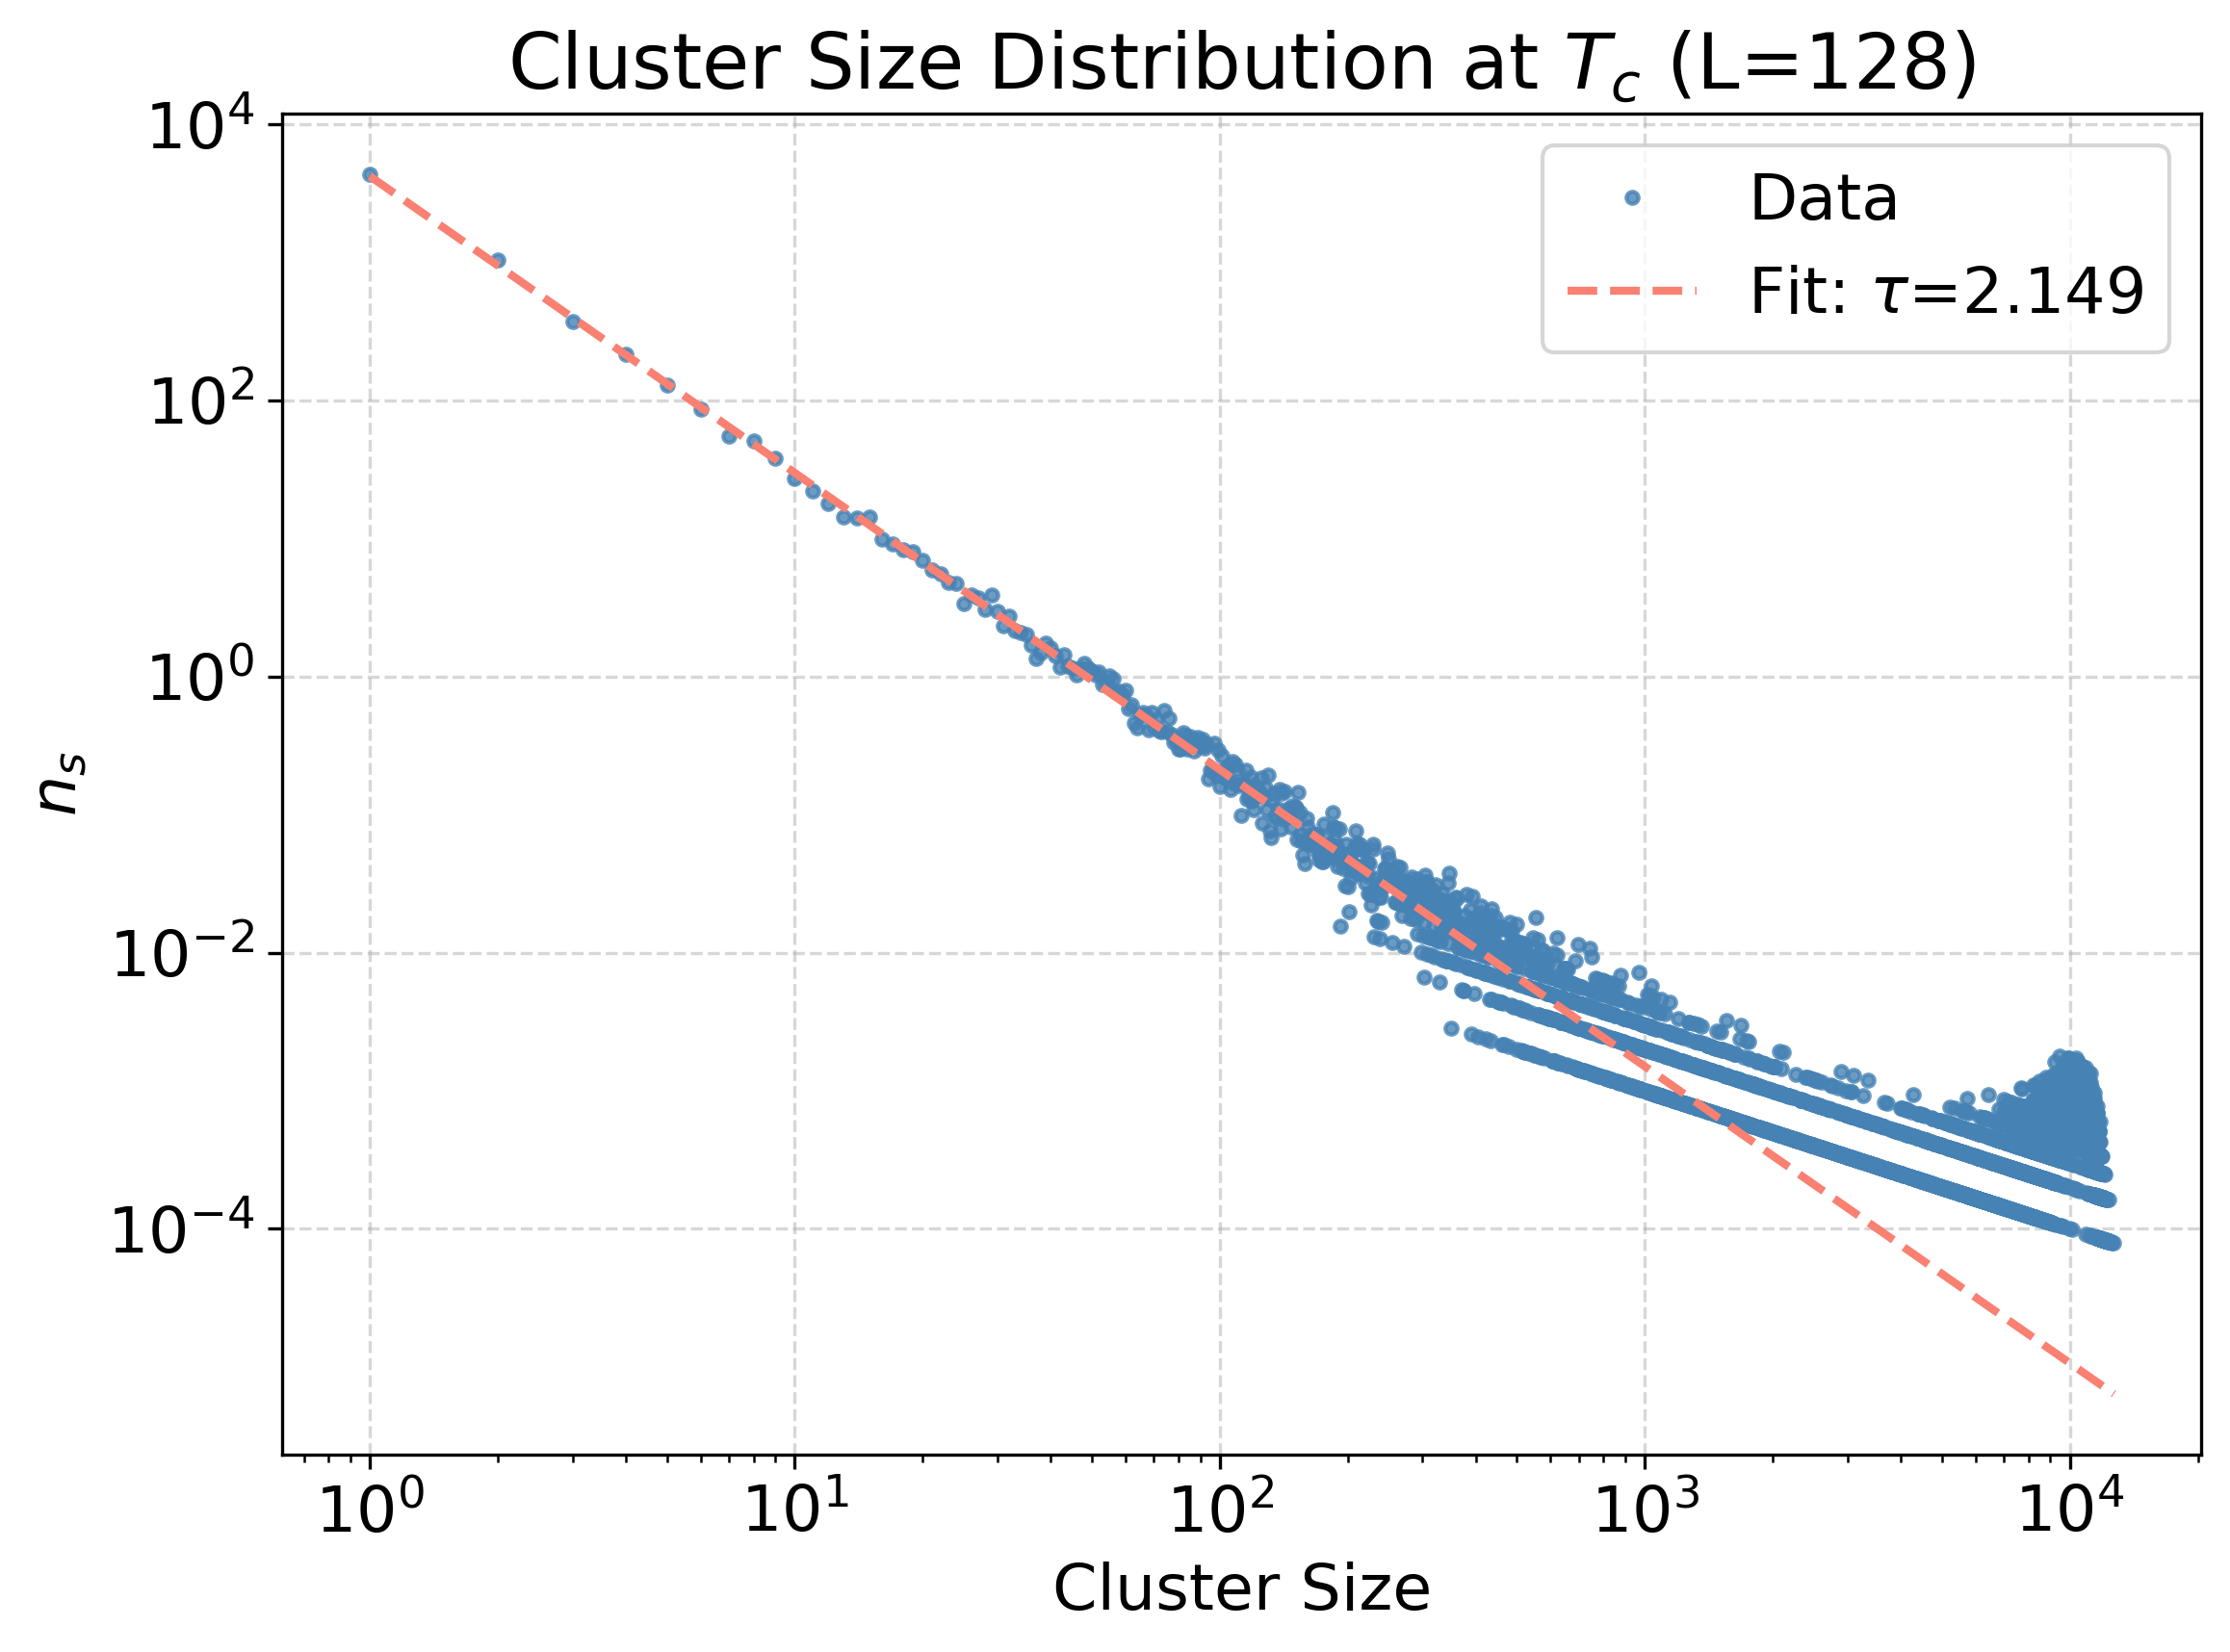

In [33]:
tau_n, inter_tau_n = np.polyfit(np.log(sizes[:L_site * 6]), np.log(ns[:L_site * 6]), 1)
print(f'Fisher exponent: {-tau_n:.3f}')
s_fit = np.linspace(1, sizes[-1], 100)
n_fit = np.exp(inter_tau_n) * s_fit**tau_n

fig, ax = plt.subplots(figsize=(8,6),dpi=300)
ax.loglog(sizes, ns, 'o', markersize=3, color='steelblue', label='Data', alpha=0.8)
ax.loglog(s_fit, n_fit, '--', lw=2, color='salmon', label=r'Fit: $\tau$={:.3f}'.format(-tau_n))
ax.set_xlabel('Cluster Size')
ax.set_ylabel(r'$n_s$')
ax.set_title(f'Cluster Size Distribution at $T_c$ (L={L_site})')
ax.legend()
ax.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

Estmimated $\tau_{\text{fisher}}$ closely matches the theoretical value.

### Fractal Dimension

The method to estimate the fractal dimension $D$ is based on the scaling law between the cluster size $s$ and its radius of gyration $R_g$:

$$s \sim R^{D}$$

and $D=91/48 \approx 1.896$ for 2D site-bond percolation.

In [24]:
@njit
def radis2(cluster):
    x = np.zeros(len(cluster))
    y = np.zeros(len(cluster))
    for i, (x_, y_) in enumerate(cluster):
        x[i] = x_
        y[i] = y_
    
    x_center = np.mean(x)
    y_center = np.mean(y)

    size = len(cluster)
    r2 = 1/size * np.sum((x - x_center)**2 + (y - y_center)**2)
    return r2

In [ ]:
L_site = 128
T_c = 2 / np.log(1 + np.sqrt(2))

steps_wolff_thermal = 500
steps_wolff = 50000
size_R2list = dict()

s = IsingSpins(L_site, L_site, J_val)

for _ in range(steps_wolff_thermal):
    wolffStep(s, k_B * T_c)

for i in range(steps_wolff):
    cluster_set = wolffStep(s, k_B * T_c)
    size = len(cluster_set)
    r2 = int(np.ceil(radis2(cluster_set)))
    if r2 in size_R2list:
        size_R2list[r2].append(size)
    else:
        size_R2list[r2] = [size]

size_R2 = dict()
for r2, size_list in size_R2list.items():
    size_R2[r2] = np.mean(size_list)

size_R2_items = sorted(size_R2.items())
sizes_Rg = np.array([item[1] for item in size_R2_items])
R2s = np.array([item[0] for item in size_R2_items])
Rg = np.sqrt(R2s)

Fractal dimension D: 1.933


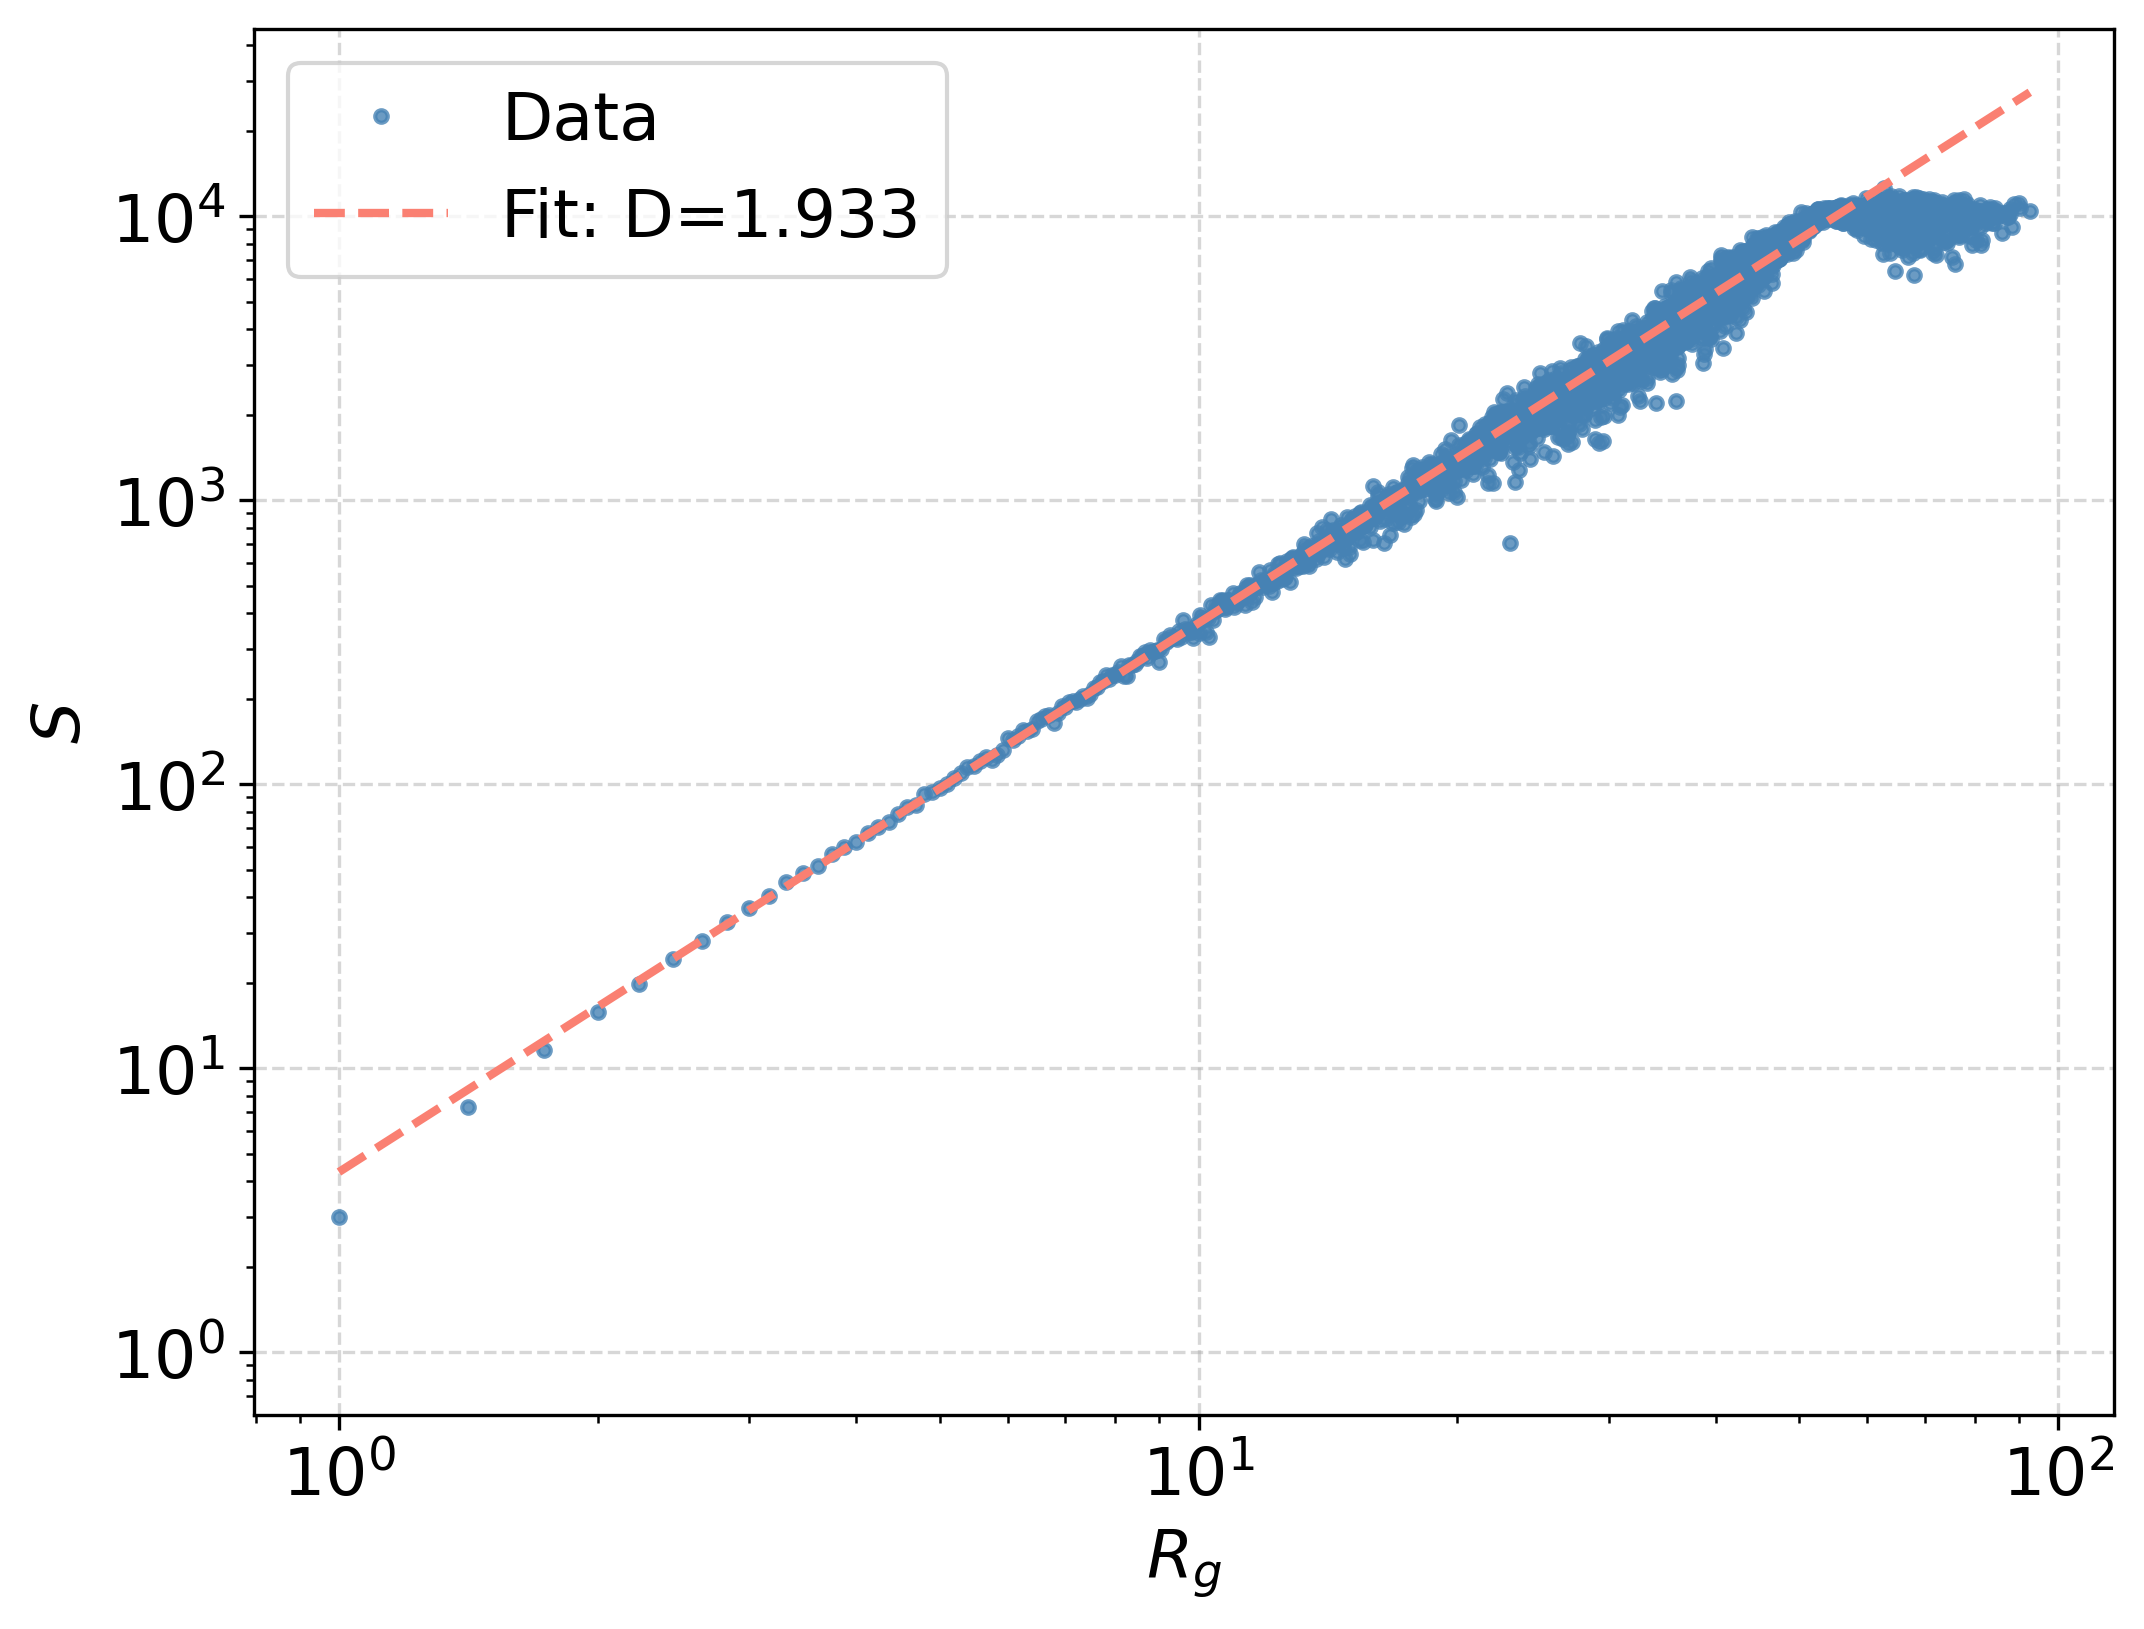

In [34]:
idx = (Rg > 1) & (Rg < L_site / 10)
D, inter_D = np.polyfit(np.log(Rg[idx]), np.log(sizes_Rg[idx]), 1)

print(f'Fractal dimension D: {D:.3f}')

Rg_fit = np.linspace(1, Rg[-1], 100)
sizes_fit = np.exp(inter_D) * Rg_fit**D

fig, ax = plt.subplots(figsize=(8,6),dpi=300)
ax.loglog(Rg, sizes_Rg, 'o', markersize=3, color='steelblue', label='Data', alpha=0.8)
ax.loglog(Rg_fit, sizes_fit, '--', lw=2, color='salmon', label=r'Fit: D={:.3f}'.format(D))
ax.set_xlabel(r'$R_g$')
ax.set_ylabel(r'$S$')
ax.legend()
ax.grid(ls='--', alpha=0.5)
plt.show()

As can be seen from the graph, both the calculations of $\tau$ and $D$ exhibit a certain deviation from the ideal scaling law at large cluster sizes. This is because the probability of generating large cluster sizes is very low, resulting in insufficient sampling data.

## Phase Classification

Convolutional Neural Network (CNN) is perfect for phase classification tasks of 2D Ising model due to its ability to capture spatial hierarchies in data. In 2D Ising model, we want the CNN can identify 3 kinds of patterns: 

1. Ordered phase of ferromagnet where spins align to form large clusters.
2. Ordered phase of antiferromagnet where spins align in a checkerboard pattern.
3. Disordered phase where spins are randomly oriented.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.patches as patches

We use Monte Carlo simulations (Wolff algorithm) to generate spin configurations at various temperatures.

In [36]:
torch.manual_seed(42)
np.random.seed(42)

Tc = 2 / np.log(1 + np.sqrt(2))

def generate_three_phase_data(n_samples=2000, L=32):
    """
    Generate synthetic Ising model data for three phases:
    Label 0: Disordered 
    Label 1: ferromagnetic (FM)
    Label 2: antiferromagnetic (AFM)
    """
    data = []
    labels = []
    pbar = tqdm(range(n_samples), desc="Generating Data")
    for _ in pbar:
        # randomly select a phase (0, 1, 2)
        label = np.random.randint(0, 3)
        if label == 0:
            # --- Label 0: Disordered ---
            T = np.random.uniform(Tc+0.1, 5.0)  # High temperature range
            s = IsingSpins(L, L, 1)
            multipleSteps(s, k_B * T, 150, 'wolff', False)
            snapshot = s.to_numpy()
        elif label == 1:
            # --- Label 1: Ferromagnetic (FM) ---
            T = np.random.uniform(1.5, Tc - 0.1)  # Low temperature range
            s = IsingSpins(L, L, 1)
            multipleSteps(s, k_B * T, 150, 'wolff', False)
            snapshot = s.to_numpy()
        else: # label == 2
            # --- Label 2: Antiferromagnetic (AFM) ---
            T = np.random.uniform(1.5, Tc - 0.1)  # Low temperature range
            s = IsingSpins(L, L, -1)
            multipleSteps(s, k_B * T, 150, 'wolff', False)
            snapshot = s.to_numpy()
    
        data.append(snapshot)
        labels.append(label)
    pbar.close()
    # CNN input dimensions: (Batch, Channels=1, Height, Width)
    X = torch.tensor(np.array(data), dtype=torch.float32).unsqueeze(1) 
    y = torch.tensor(labels, dtype=torch.long)
    return X, y

# Set standard size and data amount
L = 32
X, y = generate_three_phase_data(n_samples=3000, L=L)

# Split and load
train_size = int(0.8 * len(X))
train_dataset = TensorDataset(X[:train_size], y[:train_size])
test_dataset = TensorDataset(X[train_size:], y[train_size:])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Data generation complete, size: {L}x{L}")
print(f"Training samples: {len(train_dataset)}, test samples: {len(test_dataset)}")

Generating Data: 100%|██████████| 3000/3000 [00:52<00:00, 57.62it/s]

Data generation complete, size: 32x32
Training samples: 2400, test samples: 600


Select examples for each phase to display the characteristic patterns.

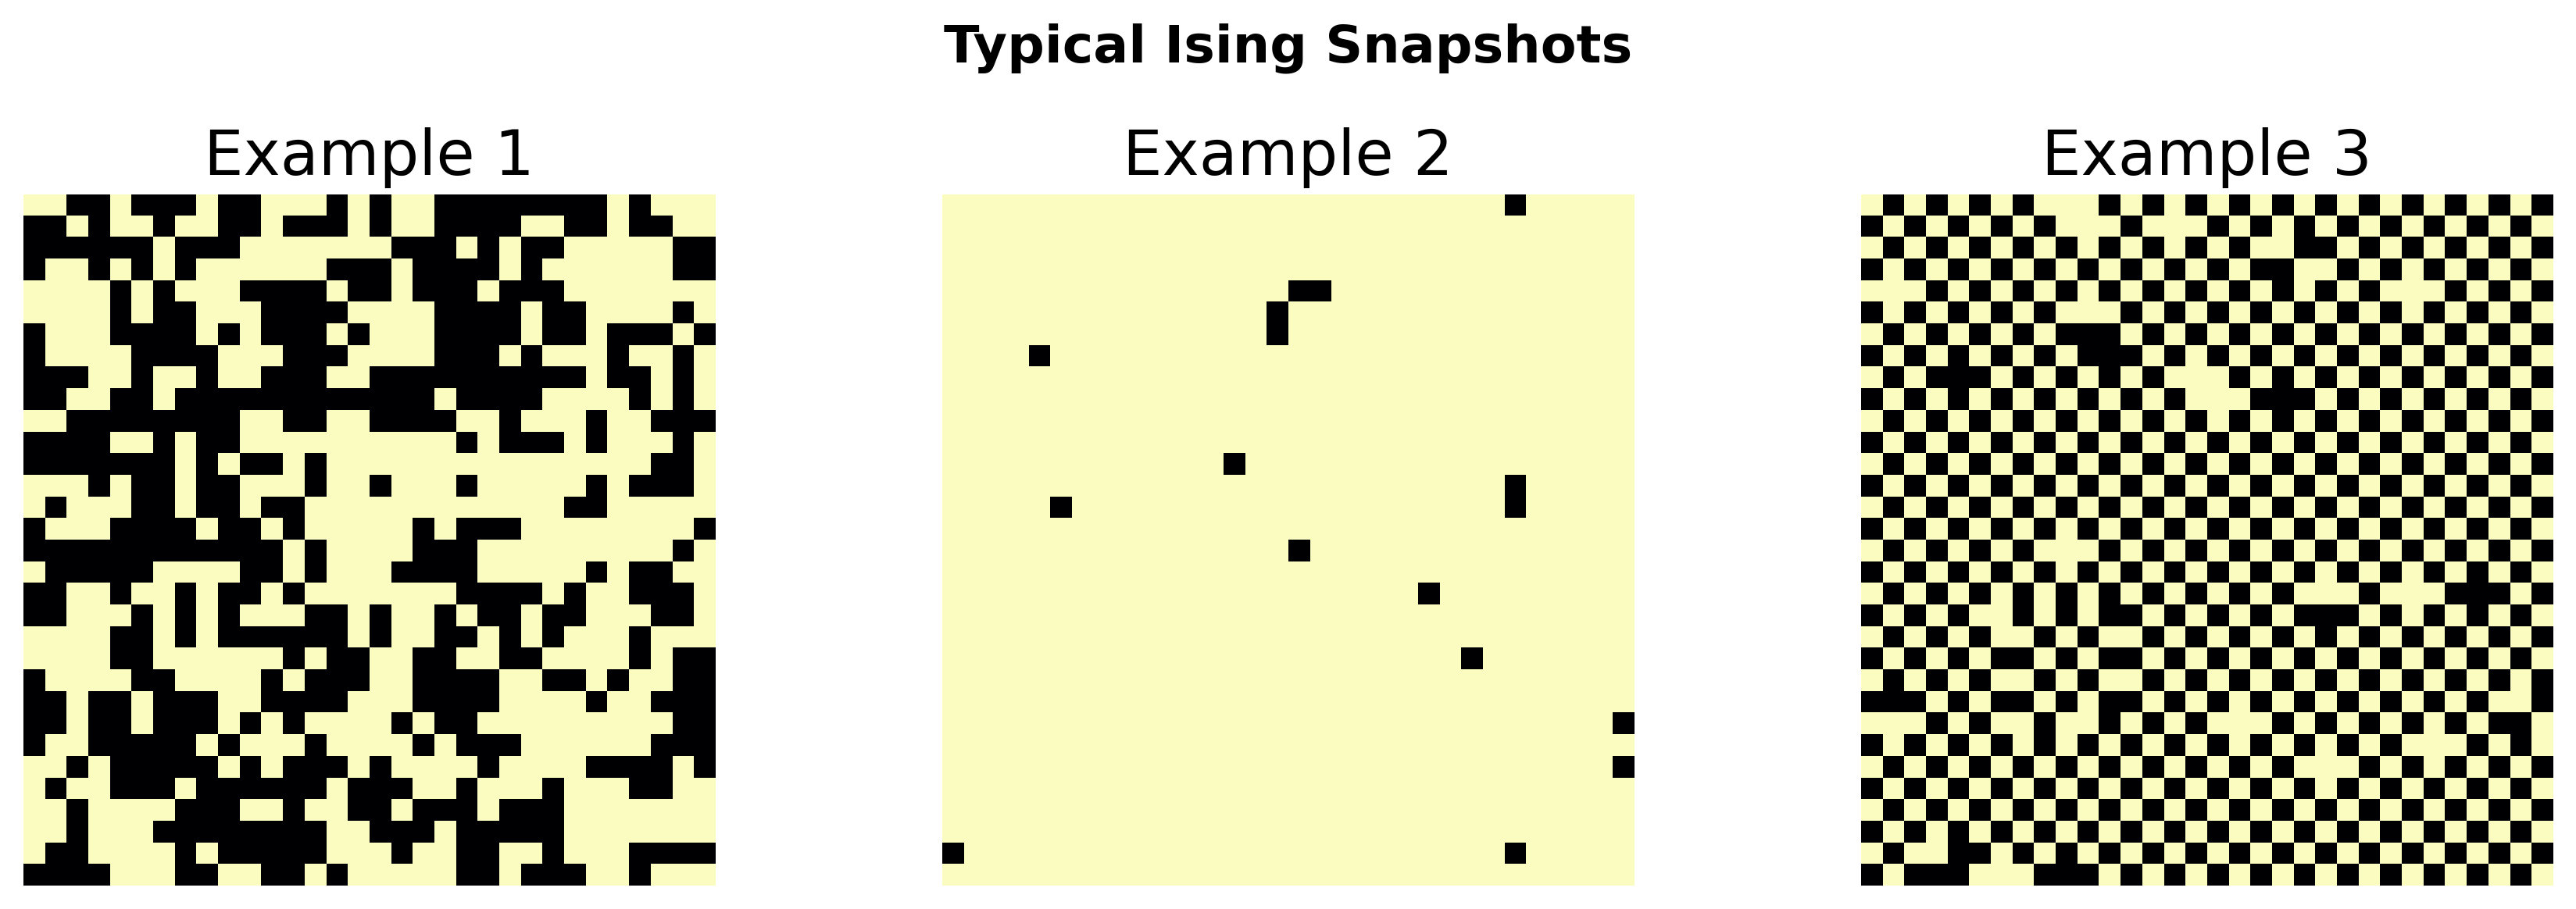

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4),dpi=300)

# Select examples for each phase
samples = [X[y==0][0], X[(y==1) & (X.mean(dim=(1,2,3)) > 0.5)][0], X[(y==2) & (X.mean(dim=(1,2,3)).abs() < 0.2)][0]]

for i, ax in enumerate(axes):
    ax.imshow(samples[i].squeeze(), cmap='magma', vmin=-1, vmax=1)
    ax.set_title(f"Example {i+1}")
    ax.axis('off')
fig.suptitle("Typical Ising Snapshots", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
class TriplePhaseClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(TriplePhaseClassifier, self).__init__()
        
        # Define convolutional blocks
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            # Block 2
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # # Block 3
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(64, num_classes) # Output 3 classes
        )

    def get_embedding(self, x):
        # Extract feature embeddings before classification.
        x = self.features(x)
        x = self.adaptive_pool(x)
        return x.view(x.size(0), -1)
        
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x) 
        x = x.view(x.size(0), -1) 
    
        # Classify
        x = self.classifier(x)
        return x

In [ ]:
class EasyModel(nn.Module):
    def __init__(self, num_classes=3):
        super(EasyModel, self).__init__()
        
        # Define convolutional blocks
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            # Block 2
            nn.Conv2d(4, 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(2, num_classes) # Output 3 classes
        )

    def get_embedding(self, x):
        # Extract feature embeddings before classification.
        x = self.features(x)
        x = self.adaptive_pool(x)
        return x.view(x.size(0), -1)
        
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x) 
        x = x.view(x.size(0), -1) 
    
        # Classify
        x = self.classifier(x)
        return x

In [45]:
model = TriplePhaseClassifier(num_classes=3)
# model = EasyModel(num_classes=3)
print("Model architecture:\n", model)

Model architecture:
 TriplePhaseClassifier(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=3, bias=True)
  )
)


Training CNN on cpu for 30 epochs...


Training: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, Loss=0.0002]


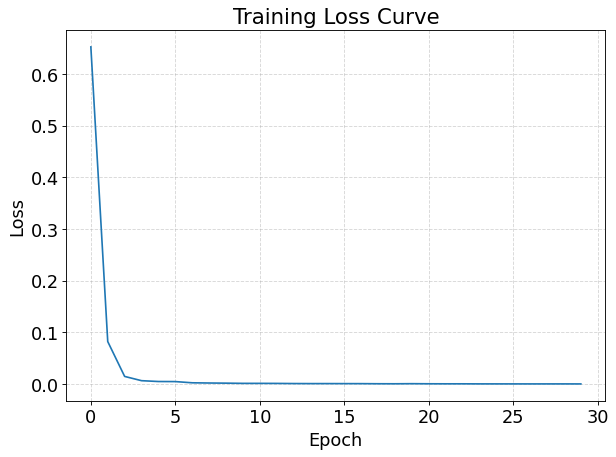

In [46]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

if model.__class__.__name__ == "EasyModel":
    epochs = 200
else:
    epochs = 30


loss_history = []

print(f"Training CNN on {device} for {epochs} epochs...")

pbar = tqdm(range(epochs), desc="Training")
for epoch in pbar:
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    
    pbar.set_postfix({"Loss": f"{epoch_loss:.4f}"})

pbar.close()

fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.plot(loss_history)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss Curve")
ax.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [47]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.2%}")

Test Accuracy: 99.83%


The test accuracy reaches over 99%, indicating the CNN's effectiveness in distinguishing between different phases of the 2D Ising model.

tensor([[[[-0.1555,  0.0677, -0.2472],
          [-0.1432,  0.1047,  0.4081],
          [ 0.3518, -0.3221, -0.0590]]],


        [[[-0.1233, -0.0938,  0.0388],
          [-0.2079, -0.1470, -0.4006],
          [-0.1885, -0.4035,  0.0459]]],


        [[[-0.3014, -0.1114, -0.2703],
          [ 0.3229, -0.1558,  0.3774],
          [-0.1999,  0.3318, -0.1067]]],


        [[[-0.2888,  0.3420, -0.2559],
          [-0.1962,  0.2343, -0.0026],
          [ 0.0324,  0.4106, -0.2940]]]])


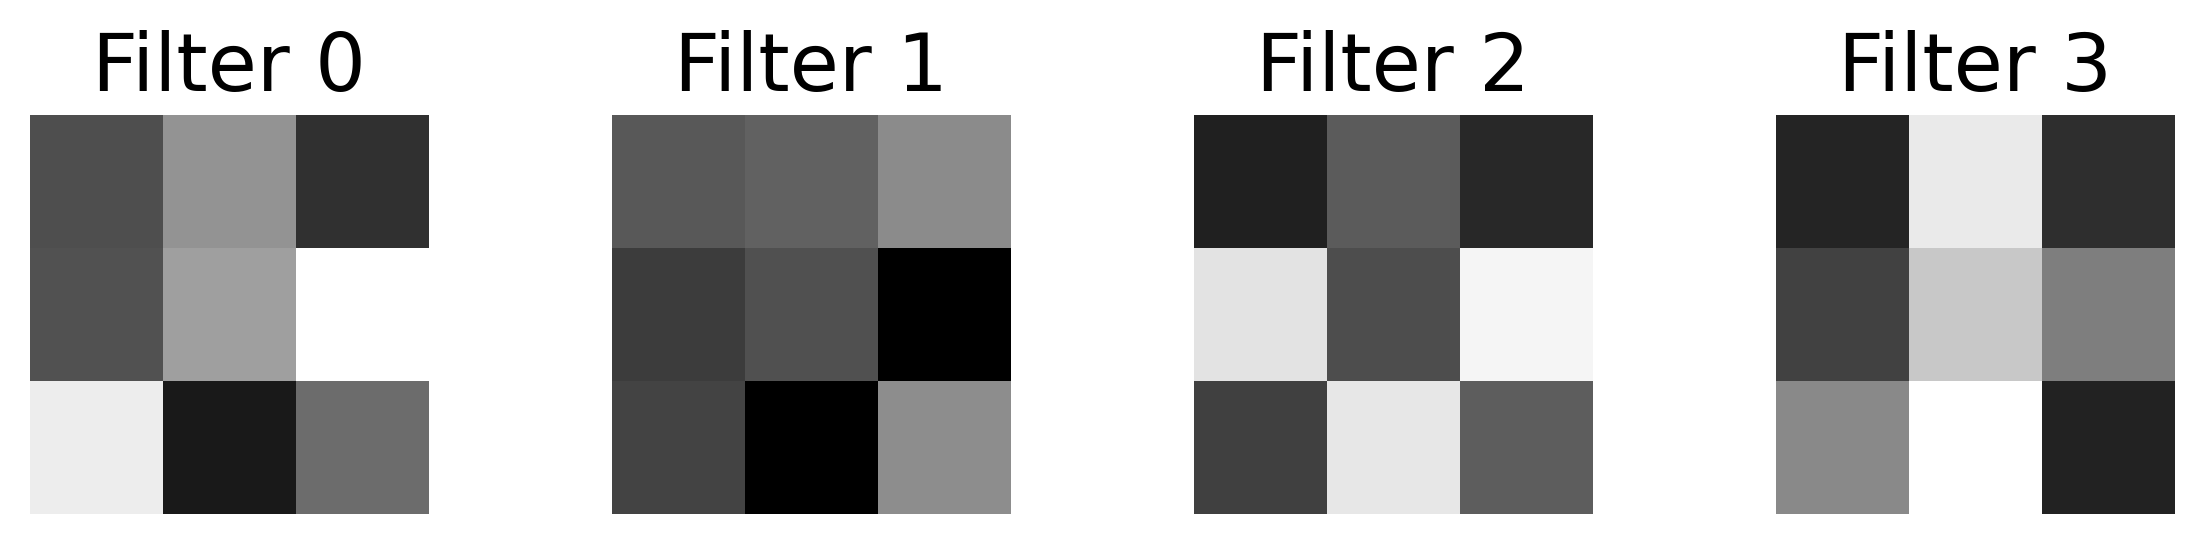

In [ ]:
W = model.features[0].weight.detach().cpu()

fig, axes = plt.subplots(1, 4, figsize=(8, 2), dpi=300)

for i in range(4):
    ax = axes[i]
    ax.imshow(W[i, 0], cmap='gray', vmin=W.min(), vmax=W.max())
    ax.set_title(f'Filter {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


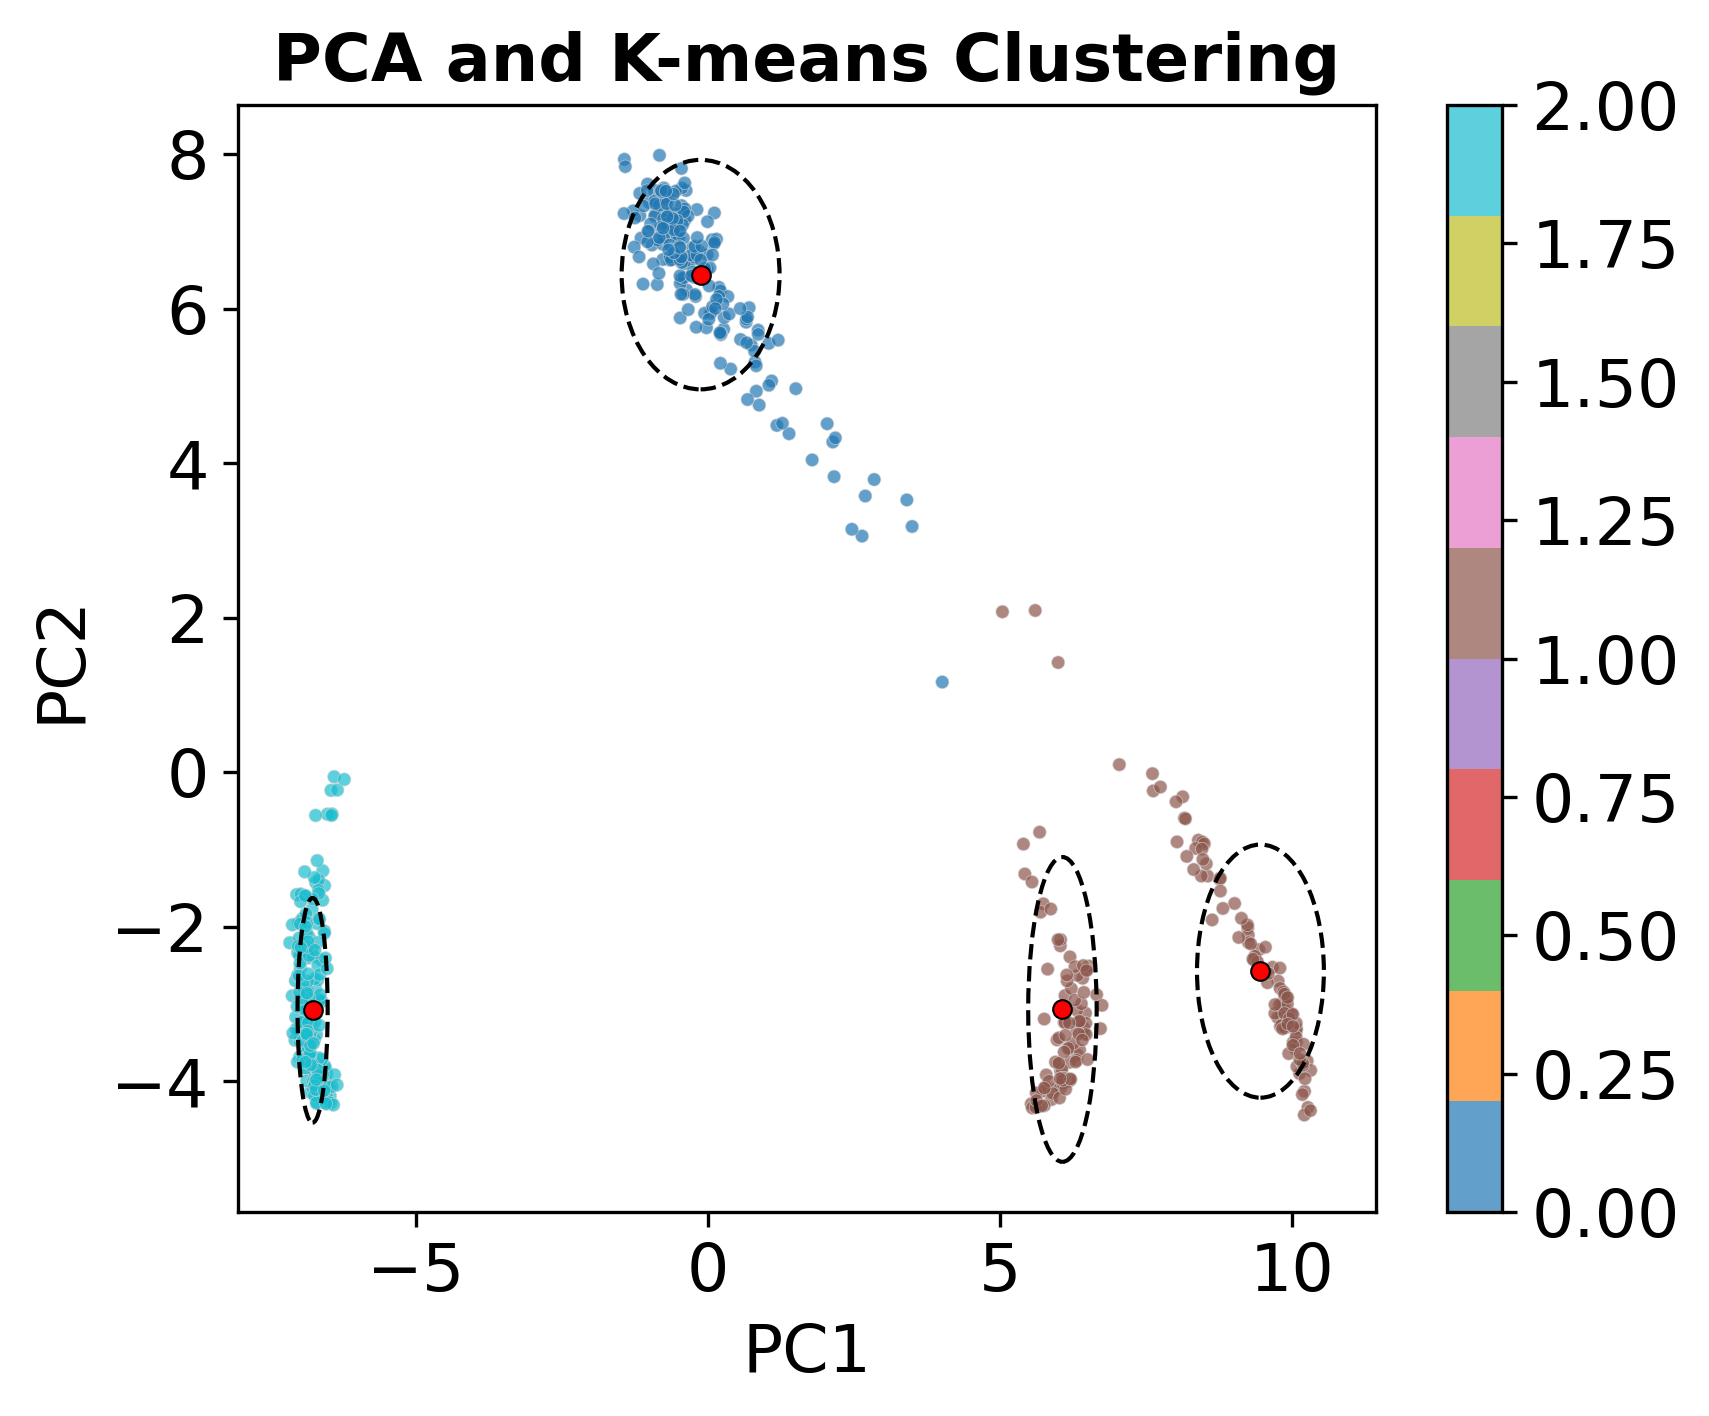

In [50]:
model.eval()

embeddings = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        z = model.get_embedding(x)    
        embeddings.append(z.cpu())
        labels.append(y)

embeddings = torch.cat(embeddings).numpy()  
labels = torch.cat(labels).numpy()

# embeddings from previous step
X = StandardScaler().fit_transform(embeddings)
pca = PCA(n_components=2)
Z = pca.fit_transform(X)

# k-means clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(Z)


fig, ax = plt.subplots(figsize=(6,5), dpi=300)
scatter = ax.scatter(Z[:,0], Z[:,1], c=labels, cmap='tab10', s=10, alpha=0.7, edgecolors='lightgray', linewidth=0.2)

# plot cluster centers and 3 sigma circles
for i in range(k):
    cluster_points = Z[cluster_labels == i]
    center = cluster_points.mean(axis=0)
    std_dev = cluster_points.std(axis=0)
    
    # plot center
    ax.scatter(center[0], center[1], c='r', s=20, marker='o', edgecolors='black', linewidth=0.5)

    # plot 3-sigma circle
    ellipse = patches.Ellipse((center[0], center[1]), width=3*std_dev[0], height=3*std_dev[1], edgecolor='black', facecolor='none', linestyle='--', linewidth=1)
    ax.add_patch(ellipse)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA and K-means Clustering', fontsize=16, fontweight='bold')
plt.colorbar(scatter)
plt.tight_layout()
plt.show()